## Imports

I imported standard libraries for utility, but ensured all core data manipulation and modeling rely on PySpark functions and ML libraries to keep the workflow entirely scalable and memory-efficient.

In [1]:
import math
import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

from typing import Literal

import findspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import IntegerType, NumericType, DoubleType
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, RobustScaler
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor
from xgboost.spark import SparkXGBRegressor

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

/Users/nickdelucchi/anaconda3/envs/spark_env/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Load Data

To handle the massive scale of this time-series dataset, I leveraged PySpark(and PySpark-compatible XGBoost) for all data processing, feature engineering, and model training. The Spark environment provides the necessary distributed computing power for performance at scale.

In [ ]:
# Initialize findspark
findspark.init()

# Create the SparkSession
# .appName(): A human-readable name for your application
# .config(): Allows setting custom Spark configuration properties
spark = (
    SparkSession.builder
    .appName("Time Series Analysis - Web Traffic")
    .config("spark.executor.memory", "24g")
    .config("spark.driver.memory", "16g")
    .config("spark.driver.maxResultSize", "4g")
    .getOrCreate()
)

## Disable ANSI SQL mode for compatibility
spark.conf.set("spark.sql.ansi.enabled", "false")

# Set the log level to ERROR or WARN to minimize output
sc = spark.sparkContext
sc.setLogLevel("ERROR") # or "WARN"

print(f"Spark Version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/11 13:19:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/11 13:19:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark Version: 4.0.1


In [3]:
## Path to data file
file_path = "data/web_traffic_train.csv"

## Load the data
train = (
    spark.read.format("csv")
    .option("header", "true")      # Treat the first row as column names
    .option("inferSchema", "true") # Automatically determine column data types
    .load(file_path)
)

print("Data Loaded Successfully!")

Data Loaded Successfully!


In [ ]:
## Print Schema of the data
train.printSchema()

## Print record count
print(f"Number of records: {train.count()}") 
## 102,994,730 records

## Print first 5 records
train.show(5)

root
 |-- series_name: string (nullable = true)
 |-- timestamp: date (nullable = true)
 |-- TrafficCount: double (nullable = true)



Number of records: 102994730
+-----------+----------+------------+
|series_name| timestamp|TrafficCount|
+-----------+----------+------------+
|         T1|2015-07-01|        18.0|
|         T1|2015-07-02|        11.0|
|         T1|2015-07-03|         5.0|
|         T1|2015-07-04|        13.0|
|         T1|2015-07-05|        14.0|
+-----------+----------+------------+
only showing top 5 rows


In [5]:
def get_missing_value_counts(df: DataFrame):
    """
    Calculate and print the count of missing values (NULLs and NaNs) for each column in the DataFrame.
    
    Parameters:
    df (DataFrame): The input PySpark DataFrame to analyze.
    """
    ## Initialize dictionary to hold missing counts
    count_expressions = []

    ## Iterate through columns and build the aggregate expression
    for column in df.columns:
        col_type = df.schema[column].dataType

        ## Check for both NULL and NaN only if the column is a numeric type
        if isinstance(col_type, NumericType):
            ## Count (col is null) OR (col is NaN)
            missing_cond = F.col(column).isNull() | F.isnan(F.col(column))
        else:
            ## Check only for standard NULL values for non-numeric types
            missing_cond = F.col(column).isNull()
        
        ## Create the aggregate expression: sum(CASE WHEN missing_cond THEN 1 ELSE 0 END)
        count_expressions.append(F.sum(F.when(missing_cond, 1).otherwise(0)).alias(column))

    ## Execute the aggregation in a single pass
    missing_counts_row = df.agg(*count_expressions).collect()[0]

    return missing_counts_row

## Get missing value counts
missing_counts_row = get_missing_value_counts(train)

## Print the results
print("Missing Value Counts by Column:")
for column in train.columns:
    print(f"  '{column}': {missing_counts_row[column]}")

Missing Value Counts by Column:
  'series_name': 0
  'timestamp': 0
  'TrafficCount': 6711273


In [6]:
unique_count = train.select('series_name').distinct().count()
print(f"Number of unique series: {unique_count}")

# Define the start date for the first validation window
min_date = train.select(F.min("timestamp")).collect()[0][0]
# Use the max date of the training set as the final limit
max_date = train.select(F.max("timestamp")).collect()[0][0]
print(f"Data ranges from {min_date} to {max_date}")

Number of unique series: 145063


Data ranges from 2015-07-01 to 2017-06-09


In [8]:
# Select the necessary columns (your date column, traffic column, and series name)
df_collected = train.select('timestamp', 'TrafficCount', 'series_name').toPandas()

plt.figure(figsize=(12, 6))

# Iterate over each unique series and plot it
for series in df_collected['series_name'].unique():
    subset = df_collected[df_collected['series_name'] == series]
    
    # Plotting the line with an alpha value
    plt.plot(
        subset['timestamp'], 
        subset['TrafficCount'], 
        label=series, 
        alpha=0.25,
        linewidth=1
    )

plt.title('Web Traffic Series Overview')
plt.xlabel('Date')
plt.ylabel('Traffic Count')
plt.grid(True, linestyle=':', alpha=0.6)

# You can keep the mean line for context
plt.axhline(df_collected['TrafficCount'].mean(), color='red', linestyle='--', linewidth=1, label='Overall Mean')
plt.legend([],[], frameon=False) # Hiding the large legend

plt.savefig('figures/all_series_line_plot.png')
plt.show()
plt.close()

Py4JJavaError: An error occurred while calling o116.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at scala.collection.mutable.ArrayBuffer$.scala$collection$mutable$ArrayBuffer$$ensureSize(ArrayBuffer.scala:332)
	at scala.collection.mutable.ArrayBuffer.ensureSize(ArrayBuffer.scala:69)
	at scala.collection.mutable.ArrayBuffer.addOne(ArrayBuffer.scala:143)
	at scala.collection.mutable.ArrayBuffer.addOne(ArrayBuffer.scala:42)
	at scala.collection.mutable.Growable.$plus$eq(Growable.scala:36)
	at scala.collection.mutable.Growable.$plus$eq$(Growable.scala:36)
	at scala.collection.mutable.AbstractBuffer.$plus$eq(Buffer.scala:314)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$2(SparkPlan.scala:463)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$4145/0x00000001400e87a0.apply(Unknown Source)
	at scala.collection.IterableOnceOps.foreach(IterableOnce.scala:619)
	at scala.collection.IterableOnceOps.foreach$(IterableOnce.scala:617)
	at org.apache.spark.util.NextIterator.foreach(NextIterator.scala:21)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:463)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:462)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$4144/0x00000001400e83d0.apply(Unknown Source)
	at scala.collection.ArrayOps$.foreach$extension(ArrayOps.scala:1324)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:462)
	at org.apache.spark.sql.classic.Dataset.$anonfun$collectToPython$1(Dataset.scala:2057)
	at org.apache.spark.sql.classic.Dataset$$Lambda$4228/0x000000014011d200.apply(Unknown Source)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$2(Dataset.scala:2234)
	at org.apache.spark.sql.classic.Dataset$$Lambda$2562/0x000000013fd46a58.apply(Unknown Source)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$1(Dataset.scala:2232)
	at org.apache.spark.sql.classic.Dataset$$Lambda$2185/0x000000013fc31210.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$2215/0x000000013fc3c940.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$2211/0x000000013fc37610.apply(Unknown Source)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager$$Lambda$2212/0x000000013fc378d8.apply(Unknown Source)


Traffic count data often exhibits high variance and is bounded at zero. To stabilize the variance and improve model linearity, I applied a $\mathbf{\ln(x+1)}$ transformation to the target variable, TrafficCount. This is a crucial step for producing normally-distributed residuals.

In [ ]:
def log_transform(df, target_col="TrafficCount"):
    """
    Applies a log(X + 1) transformation to the target column to normalize 
    the scale and variance, and prepares the inverse function for later.

    Args:
        df (DataFrame): The input PySpark DataFrame.
        target_col (str): The name of the original target column.

    Returns:
        DataFrame: The DataFrame with the new log-transformed target column.
    """
    new_target_col = f"log_{target_col}"
    
    # Apply log(X + 1) transformation
    df_transformed = df.withColumn(
        new_target_col,
        F.log1p(F.col(target_col))  # log1p is equivalent to log(X + 1)
    )
    
    return df_transformed

def inverse_log_transform(predictions_df, log_predicted_col):
    """
    Applies the inverse transformation (e^X - 1) to the predicted log values
    to get the final predicted traffic counts in the original scale.

    Args:
        predictions_df (DataFrame): The DataFrame containing log-transformed predictions.
        log_predicted_col (str): The column name containing the log-transformed predictions.

    Returns:
        DataFrame: The DataFrame with the final, un-transformed predicted counts.
    """
    final_predicted_col = log_predicted_col.replace("log_", "nonlog_")
    
    # Apply the inverse: exp(X) - 1
    df_inverse = predictions_df.withColumn(
        final_predicted_col,
        F.expm1(F.col(log_predicted_col)) # expm1 is equivalent to exp(X) - 1
    )
    
    # Ensure predicted counts are not negative (possible due to model error)
    df_inverse = df_inverse.withColumn(
        final_predicted_col,
        F.when(F.col(final_predicted_col) < 0, 0).otherwise(F.col(final_predicted_col))
    )
    
    return df_inverse

In [9]:
train = log_transform(train, target_col="TrafficCount")
train.show(5)

NameError: name 'log_transform' is not defined

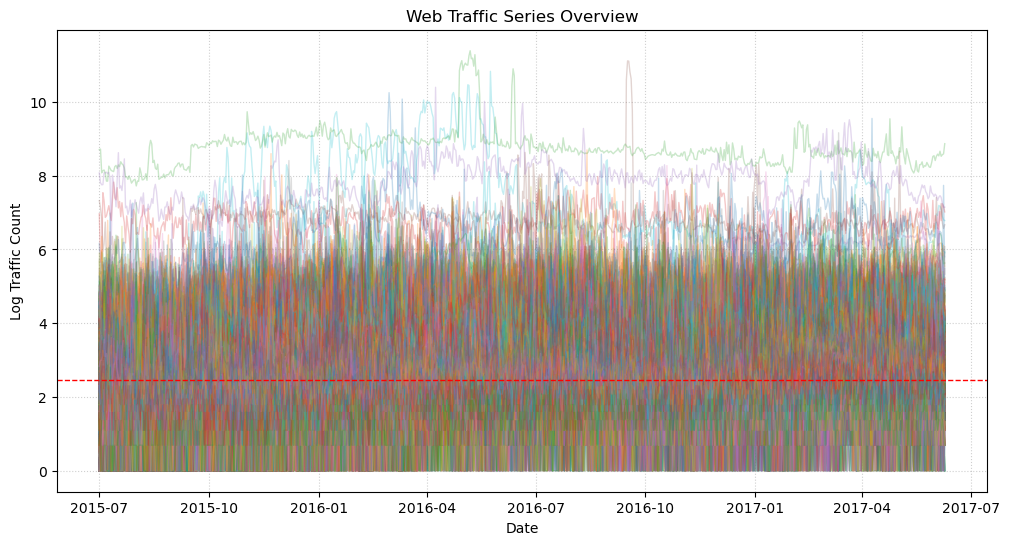

In [ ]:
# Select the necessary columns (your date column, traffic column, and series name)
df_collected = train.select('timestamp', 'log_TrafficCount', 'series_name').toPandas()

plt.figure(figsize=(12, 6))

# Iterate over each unique series and plot it
for series in df_collected['series_name'].unique():
    subset = df_collected[df_collected['series_name'] == series]
    
    # Plotting the line with an alpha value
    plt.plot(
        subset['timestamp'], 
        subset['log_TrafficCount'], 
        label=series, 
        alpha=0.25,
        linewidth=1
    )

plt.title('Web Traffic Series Overview')
plt.xlabel('Date')
plt.ylabel('Log Traffic Count')
plt.grid(True, linestyle=':', alpha=0.6)

# You can keep the mean line for context
plt.axhline(df_collected['log_TrafficCount'].mean(), color='red', linestyle='--', linewidth=1, label='Overall Mean')
plt.legend([],[], frameon=False) # Hiding the large legend

plt.savefig('all_series_log_line_plot.png')
plt.show()
plt.close()

## Feature Engineering

### Handle Missing Values

In [12]:
def fill_by_series(
    df: DataFrame, 
    series_col: str, 
    time_col: str, 
    fill_col: str, 
    strategy: Literal["ffill", "bfill"] = "ffill"
) -> DataFrame:
    """
    Performs a Forward Fill (ffill) or Backward Fill (bfill) on a column, 
    partitioned by a series identifier.

    Args:
        df: The PySpark DataFrame.
        series_col: The column name for the series/grouping (e.g., 'series_name').
        time_col: The column name for the time ordering (e.g., 'timestamp').
        fill_col: The column name with missing values to be filled (e.g., 'TrafficCount').
        strategy: The filling direction: 'ffill' (Last Observation Carried Forward) 
        or 'bfill' (Next Observation Carried Backward).

    Returns:
        The DataFrame with the specified column filled according to the strategy.
    """
    
    # 1. Define Window Specification based on strategy
    if strategy == "ffill":
        # Window for Forward Fill (LOCF): Looks back from unbounded past to the current row.
        # This carries the LAST seen non-null value forward.
        window_spec = Window.partitionBy(series_col).orderBy(time_col).rowsBetween(
            Window.unboundedPreceding, 
            Window.currentRow
        )
        fill_func = F.last # Use F.last for ffill/LOCF
    
    elif strategy == "bfill":
        # Window for Backward Fill (NOCB): Looks forward from the current row to the unbounded future.
        # This carries the NEXT seen non-null value backward.
        window_spec = Window.partitionBy(series_col).orderBy(time_col).rowsBetween(
            Window.currentRow, 
            Window.unboundedFollowing
        )
        fill_func = F.first # Use F.first for bfill/NOCB (since we are reading forward)
        
    else:
        raise ValueError("Strategy must be 'ffill' or 'bfill'")
    
    # 2. Apply the window function
    df_filled = df.withColumn(
        f"{fill_col}_temp",
        fill_func(F.col(fill_col), ignorenulls=True).over(window_spec)
    )
    
    # 3. Replace the original column and return
    df_final = df_filled.drop(fill_col) \
                        .withColumnRenamed(f"{fill_col}_temp", fill_col)
    
    return df_final

def forward_then_backward_fill(
    df: DataFrame, 
    series_col: str, 
    time_col: str, 
    fill_col: str
) -> DataFrame:
    """
    Performs a chained imputation: Forward Fill first, followed by Backward Fill.
    This handles missing values at the beginning, middle, and end of each series.
    """
    print(f"Applying Forward Fill (ffill) to '{fill_col}'...")
    df_ffilled = fill_by_series(df, series_col, time_col, fill_col, strategy="ffill")
    
    # Check if all values were filled (often, only those at the start remain missing)
    initial_missing = df_ffilled.filter(F.col(fill_col).isNull()).count()
    if initial_missing > 0:
        print(f"  {initial_missing} missing values remain after ffill. Applying Backward Fill (bfill)...")
        # Apply Bfill to the ffilled DataFrame
        df_final = fill_by_series(df_ffilled, series_col, time_col, fill_col, strategy="bfill")
        print("  Bfill complete.")
        return df_final
    else:
        print("  All values filled by ffill.")
        return df_ffilled

In [13]:
imputed_df = forward_then_backward_fill(df=train, 
                                        series_col="series_name", 
                                        time_col="timestamp", 
                                        fill_col="TrafficCount"
)

## Get missing value counts
missing_counts_row = get_missing_value_counts(imputed_df)

## Print the results
print("Missing Value Counts by Column:")
for column in imputed_df.columns:
    print(f"  '{column}': {missing_counts_row[column]}")

Applying Forward Fill (ffill) to 'TrafficCount'...


  15115 missing values remain after ffill. Applying Backward Fill (bfill)...
  Bfill complete.


Missing Value Counts by Column:
  'series_name': 0
  'timestamp': 0
  'TrafficCount': 0


### Create New Features

Before training, I prepare some essential features: I convert the timestamp column into granular temporal components, which are vital for capturing seasonality, and then use Spark Window Functions to calculate rolling averages and lags.

In [14]:
def add_time_features(df: DataFrame) -> DataFrame:
    """
    Add time features to a DataFrame.

    Args:
        df (pyspark.sql.dataframe.DataFrame): The input DataFrame.

    Returns:
        pyspark.sql.dataframe.DataFrame: The DataFrame with time features added.
    """

    # Ensure the timestamp column is a proper date/timestamp type
    df = df.withColumn("timestamp", F.to_date(F.col("timestamp")))
    
    return df.withColumn("day_of_week", F.dayofweek("timestamp")) \
            .withColumn("day_of_month", F.dayofmonth("timestamp")) \
            .withColumn("day_of_quarter", F.datediff("timestamp", F.date_trunc("quarter", "timestamp")) + 1) \
            .withColumn("day_of_year", F.dayofyear("timestamp")) \
            .withColumn("month", F.month("timestamp")) \
            .withColumn("year", F.year("timestamp")) \
            .withColumn("week_of_month", F.ceil(F.dayofmonth("timestamp") / 7).cast("int")) \
            .withColumn("week_of_quarter",F.ceil(F.col("day_of_quarter") / 7).cast("int")) \
            .withColumn("week_of_year", F.weekofyear("timestamp")) \
            .withColumn("quarter", F.quarter("timestamp")) \
            .withColumn("is_weekend", F.when(F.dayofweek("timestamp").isin([1, 7]), 1).otherwise(0))

In [15]:
def get_is_holiday(df, column_name="timestamp"):
    # Calculate the min and max years on the driver
    min_date_ts = df.select(F.min(column_name)).collect()[0][0]
    max_date_ts = df.select(F.max(column_name)).collect()[0][0]
    
    # Extract year integers from the Python datetime objects
    start_year = min_date_ts.year
    end_year = max_date_ts.year
    COUNTRY = 'US' # Set your country code

    # Create the set of holidays on the Driver (BEFORE UDF definition)
    holiday_set = set(
        holidays.country_holidays(
            COUNTRY, 
            years=range(start_year, end_year + 1)
        ).keys()
    )

    # Define the UDF (which closes over the holiday_set)
    def is_holiday_func(timestamp_val):
        """Checks if a timestamp's date part is an observed holiday."""
        if timestamp_val is None:
            return False
        
        # Convert to Python date object for lookup
        dt = timestamp_val.date() if hasattr(timestamp_val, 'date') else timestamp_val
        
        return 1 if dt in holiday_set else 0

    is_holiday_udf = F.udf(is_holiday_func, IntegerType())

    # Apply the UDF using ONLY the column reference
    df = df.withColumn(
        "is_holiday", 
        is_holiday_udf(F.col(column_name)).alias("is_holiday")
    )
    
    return df


My strategy for feature engineering focuses on capturing multi-scale trends and seasonality. I use Spark's efficient Window Functions to compute lagged traffic counts (1-day, 7-day) and rolling statistics (mean/std dev over 7 and 30 days), ensuring these calculations are partitioned correctly by series_name.

In [16]:
def add_lag_and_rolling_features(df: DataFrame) -> DataFrame:
        # Define the base window: Partition by series_name and order by timestamp
        # This ensures that lag/rolling calculations are separate for each time series.
        window_spec = Window.partitionBy("series_name").orderBy("timestamp")

        # Define Rolling Windows (The -6 / -29 is for a 7-day or 30-day window including the current day)
        # The current row is included (0) up to the 6th or 29th preceding row (for a 7-day or 30-day total window).
        window_7d = window_spec.rowsBetween(-7, -1)  # 7 days ending at previous day
        window_30d = window_spec.rowsBetween(-30, -1) # 30 days ending at previous day

        # LAG FEATURES
        df = df.withColumn("traffic_count_lag_1d", F.lag("TrafficCount", 1).over(window_spec)) \
                .withColumn("traffic_count_lag_3d", F.lag("TrafficCount", 3).over(window_spec)) \
                .withColumn("traffic_count_lag_7d", F.lag("TrafficCount", 7).over(window_spec))

        # ROLLING 7-DAY FEATURES
        df = df.withColumn("traffic_count_rolling_mean_7d", F.avg("TrafficCount").over(window_7d)) \
                .withColumn("traffic_count_rolling_std_7d", F.stddev("TrafficCount").over(window_7d))
        # Spark's built-in functions do not have a dedicated `median` window function 
        # so we will use this workaround, the percentile_approx function.
        df = df.withColumn("traffic_count_rolling_median_7d", F.percentile_approx("TrafficCount", F.lit(0.5)).over(window_7d))

        # ROLLING 30-DAY FEATURES
        df = df.withColumn("traffic_count_rolling_mean_30d", F.avg("TrafficCount").over(window_30d)) \
                .withColumn("traffic_count_rolling_std_30d", F.stddev("TrafficCount").over(window_30d))
        # Spark's built-in functions do not have a dedicated `median` window function 
        # so we will use this workaround, the percentile_approx function.
        df = df.withColumn("traffic_count_rolling_median_30d", F.percentile_approx("TrafficCount", F.lit(0.5)).over(window_30d))

        return df

Since simple numerical encoding of time (e.g., month=1 to 12) suggests a non-existent linear relationship between December and January, I use Sine/Cosine transformations for all cyclical features (day of week, month, year) to preserve the inherent cyclical distance.

In [17]:
def cyclical_encoding(df, col_name, period):
    """
    Applies sine and cosine cyclical encoding to a given column in a PySpark DataFrame.

    Args:
        df (DataFrame): The input PySpark DataFrame.
        col_name (str): The name of the column to encode (must be numeric, e.g., 'day_of_week').
        period (int): The maximum value in the cycle (e.g., 7 for day_of_week, 12 for month).

    Returns:
        DataFrame: The DataFrame with the two new encoded columns.
    """
    # Calculate the scale factor (2 * pi / period)
    scale_factor = 2 * F.pi() / period

    # Calculate the Sine component
    df = df.withColumn(
        f"{col_name}_sin",
        F.sin(F.col(col_name) * scale_factor)
    )

    # Calculate the Cosine component
    df = df.withColumn(
        f"{col_name}_cos",
        F.cos(F.col(col_name) * scale_factor)
    )

    return df

In [18]:
def apply_cyclical_encoding(df):
    time_features_dict = {'month': 12,
                        'quarter': 4,
                        'day_of_week': 7, 
                        'day_of_month': 31, 
                        'day_of_year': 366,
                        'week_of_month': 5,
                        'week_of_quarter': 13,
                        'week_of_year': 52,
                        }

    for key, value in time_features_dict.items():
        df = cyclical_encoding(df, key, value)

    # After transformation, we need to drop the original integer columns 
    # and potentially other redundant time features (like 'week_of_year', etc.)
    # to avoid multicollinearity.
    cols_to_drop = [key for key in time_features_dict]
    df = df.drop(*cols_to_drop)

    return df

### Feature Engineering Main

In [19]:
def feature_engineering(df):

    ## Apply the feature egineering functions to the DataFrame
    feat_df = add_time_features(imputed_df)
    feat_df = apply_cyclical_encoding(feat_df)
    feat_df = get_is_holiday(feat_df)
    feat_df = add_lag_and_rolling_features(feat_df)

    ## fill any remaining nulls in the specified feature columns with 0
    ## there are nulls created from the rolling features that don't have preceding values to forward fill with
    feat_df = feat_df.fillna(0)

    return feat_df

In [35]:
## Perform forward then backward fill 
imputed_df = forward_then_backward_fill(df=train, 
                                        series_col="series_name", 
                                        time_col="timestamp", 
                                        fill_col="TrafficCount"
    )

## Apply the feature egineering functions to the DataFrame
train_feat_df = feature_engineering(imputed_df)

train_feat_df.show(5)

Applying Forward Fill (ffill) to 'TrafficCount'...


  15115 missing values remain after ffill. Applying Backward Fill (bfill)...
  Bfill complete.


+-----------+----------+------------------+------------+--------------+----+----------+-------------------+-------------------+-----------+--------------------+--------------------+-------------------+-------------------+------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+------------------+----------+--------------------+--------------------+--------------------+-----------------------------+----------------------------+-------------------------------+------------------------------+-----------------------------+--------------------------------+
|series_name| timestamp|  log_TrafficCount|TrafficCount|day_of_quarter|year|is_weekend|          month_sin|          month_cos|quarter_sin|         quarter_cos|     day_of_week_sin|    day_of_week_cos|   day_of_month_sin|  day_of_month_cos|     day_of_year_sin|    day_of_year_cos| week_of_month_sin|  week_of_month_cos|week_of_quarter_sin|

### Series Clustering

I use Bisecting K-Means clustering on traffic pattern features to group similar time series together. The resulting cluster_id serves as a powerful categorical feature, allowing the model to learn distinct patterns for each group.

#### Clustering Prep

In [ ]:
def calculate_basic_clustering_stats(df: DataFrame) -> DataFrame:
    """Calculates mean, stddev, min, max, and total of TrafficCount per series."""
    series_features_df = df.groupBy("series_name").agg(
        F.mean("TrafficCount").alias("mean_traffic"),
        F.stddev("TrafficCount").alias("stddev_traffic"),
        F.min("TrafficCount").alias("min_traffic"),
        F.max("TrafficCount").alias("max_traffic"),
        F.sum("TrafficCount").alias("total_traffic"),
    ).fillna(0) 
    return series_features_df

def calculate_clustering_autocorrelation(df: DataFrame) -> DataFrame:
    """
    Calculates Lag-1 Autocorrelation per series, robustly handling constant series.
    """
    ## Create Lag Feature
    window_spec = Window.partitionBy("series_name").orderBy("timestamp")
    df_with_lag = df.withColumn(
        "traffic_count_lag_1d", 
        F.lag("TrafficCount", 1).over(window_spec)
    )
    
    ## Perform aggregation, using F.approx_count_distinct for robustness 
    ## (though F.countDistinct should work)
    ## We calculate both the variance/distinct check AND the correlation in the same pass.
    autocorr_df = df_with_lag.groupBy("series_name").agg(
        ## Check 1: Count of non-null values (need at least 2 for correlation)
        F.count("TrafficCount").alias("count"),
        
        ## Check 2: Variance (if 0, series is constant)
        F.variance("TrafficCount").alias("variance_traffic"),
        
        ## Calculate the correlation (will return NULL if variance is zero)
        F.corr("TrafficCount", "traffic_count_lag_1d").alias("raw_autocorr")
    )
    
    ## Apply the final check for zero variance or insufficient data
    autocorr_final = autocorr_df.withColumn(
        "autocorr_lag_1",
        F.when(
            ## If variance is zero (series is flat) OR count is less than 2
            (F.col("variance_traffic").isNull()) | (F.col("variance_traffic") == 0) | (F.col("count") < 2),
            F.lit(0.0) # Set to 0.0 if series is constant or too short
        ).otherwise(
            F.col("raw_autocorr")
        )
    ).select("series_name", "autocorr_lag_1")
    
    ## Fill remaining NULLs (should mostly be handled by the WHEN clause, but safe to keep)
    return autocorr_final.fillna(0)

def calculate_clustering_dow_profile(df: DataFrame) -> DataFrame:
    """Calculates the average TrafficCount for each Day of Week per series."""
    ## Note: F.dayofweek returns 1=Sunday, 2=Monday, ..., 7=Saturday
    df_with_dow = df.withColumn("day_of_week", F.dayofweek("timestamp"))

    ## Pivot to get one column per Day of Week (DOW)
    dow_profile_df = df_with_dow.groupBy("series_name").pivot("day_of_week").agg(
        F.mean("TrafficCount")
    ).fillna(0)
    
    ## Rename columns for clarity 
    dow_columns = {str(i): f"avg_traffic_dow_{i}" for i in range(1, 8)}
    
    dow_profile_df = dow_profile_df.select(
        "series_name", 
        *[F.col(str(i)).alias(dow_columns[str(i)]) for i in range(1, 8)]
    )
    
    return dow_profile_df

def calculate_clustering_trend_proxy(df: DataFrame) -> DataFrame:
    """Calculates the difference between the last and first TrafficCount per series."""
    
    window_by_series = Window.partitionBy("series_name")
    window_by_series_ordered = Window.partitionBy("series_name").orderBy("timestamp")
    
    ## Calculate rank and max_rank
    trend_df = df.withColumn("rank", F.row_number().over(window_by_series_ordered)) \
                .withColumn("max_rank", F.count(F.lit(1)).over(window_by_series))

    ## Filter for first and last points
    first_point = trend_df.filter(F.col("rank") == 1).select(
        "series_name", F.col("TrafficCount").alias("start_traffic")
    )
    last_point = trend_df.filter(F.col("rank") == F.col("max_rank")).select(
        "series_name", F.col("TrafficCount").alias("end_traffic")
    )
    
    trend_final = first_point.join(last_point, "series_name").withColumn(
        "trend_change", F.col("end_traffic") - F.col("start_traffic")
    ).select("series_name", "trend_change")
    
    return trend_final.fillna(0)

In [22]:
def create_clustering_features(df: DataFrame) -> DataFrame:
    """
    Orchestrates the calculation of all clustering features and joins them into a single DataFrame.
    
    Args:
        df: The base PySpark DataFrame (must have 'series_name', 'timestamp', and 'TrafficCount').
        
    Returns:
        A single DataFrame with 'series_name' and all calculated features.
    """
    
    ## Calculate and collect all feature sets
    stats_df = calculate_basic_clustering_stats(df)
    autocorr_df = calculate_clustering_autocorrelation(df)
    dow_profile_df = calculate_clustering_dow_profile(df)
    trend_df = calculate_clustering_trend_proxy(df)
    
    ## Sequentially join all DataFrames on the "series_name" key
    
    ## Start with basic stats
    clustering_df = stats_df
    ## Join Autocorrelation
    clustering_df = clustering_df.join(autocorr_df, "series_name", how="inner")
    ## Join DOW Profile
    clustering_df = clustering_df.join(dow_profile_df, "series_name", how="inner")
    ## Join Trend Proxy
    clustering_df = clustering_df.join(trend_df, "series_name", how="inner")
    
    ## Ensure all resulting columns are numeric for VectorAssembler
    ## This step is mostly defensive, as the individual functions already handle this.
    for col_name in clustering_df.columns:
        if col_name != "series_name" and not isinstance(clustering_df.schema[col_name].dataType, NumericType):
            ## Force casting, replacing non-convertible values with null (then filled by a final fillna(0) if necessary)
            clustering_df = clustering_df.withColumn(col_name, F.col(col_name).cast("double"))

    ## One final fill for any residual joins that might have resulted in nulls
    clustering_df = clustering_df.fillna(0)
    
    return clustering_df

In [23]:
def perform_clustering_exploration(clustering_features_df: DataFrame, K_min: int, K_max: int):
    ## Perform KMeans clustering across a range of K values to find the optimal K using the Elbow Method

    ## get list of clustering feature columns (excluding series_name)
    clustering_features_list = [column for column in clustering_features_df.columns if column != "series_name"]

    ## Assemble the summary features into a single vector
    clustering_assembler = VectorAssembler(
        inputCols=clustering_features_list,
        outputCol="clustering_features"
        ) 

    ## Define the robust scaler object
    scaler = RobustScaler(inputCol="clustering_features",
                            outputCol="clustering_features_scaled")
    
    ## Apply the assembly transformation
    clustering_assembled_df = clustering_assembler.transform(clustering_features_df)
    ## Apply the scaler transformation
    clustering_assemebled_scaled_df = scaler.fit(clustering_assembled_df).transform(clustering_assembled_df)

    clustering_results = []
    K_range = range(K_min, K_max+1)

    for K in K_range:
        print(f"Training Bisecting KMeans with K={K}...")

        ## Define Kmeans model
        bkmeans = BisectingKMeans(featuresCol="clustering_features_scaled", k=K, seed=42)
        ## Train the kmeans model
        model = bkmeans.fit(clustering_assemebled_scaled_df)

        # Inertia (WCSS) for Elbow Method
        wcss = model.summary.trainingCost
        
        clustering_results.append({
            'K': K,
            'WCSS': wcss
        })

    return clustering_results

In [24]:
def analyze_clustering_exploration(results: dict):
    # Convert to Pandas for easy plotting/analysis
    wcss_df = pd.DataFrame(results)

    ###########################################################################
    ## Calculate the Elbow Point using the "Maximum Distance to Line" method ##
    ###########################################################################

    ## --- Define the line connecting the first and last point ---

    ## Normalize the data (Crucial for distance calculation)
    ## Normalization ensures K and WCSS contribute equally to the distance calculation.
    data = wcss_df[['K', 'WCSS']].values
    K_norm = (data[:, 0] - data[:, 0].min()) / (data[:, 0].max() - data[:, 0].min())
    WCSS_norm = (data[:, 1] - data[:, 1].min()) / (data[:, 1].max() - data[:, 1].min())

    ## Get the coordinates for the reference line (P1: start, P2: end)
    P1 = np.array([K_norm[0], WCSS_norm[0]])
    P2 = np.array([K_norm[-1], WCSS_norm[-1]])

    ## --- Calculate the perpendicular distance for every point ---

    max_distance = -1
    optimal_K = -1

    ## Iterate through every point (K_i, WCSS_i)
    for i in range(len(K_norm)):
        Pi = np.array([K_norm[i], WCSS_norm[i]])
        
        ## Calculate vector P1 to Pi (v) and P1 to P2 (w)
        v = Pi - P1
        w = P2 - P1
        
        ## Calculate the area of the parallelogram defined by v and w
        ## (The numerator of the standard distance formula, using cross product for 2D)
        area = np.abs(v[0] * w[1] - v[1] * w[0])
        
        ## Calculate the length of the base (P1 to P2)
        base_length = np.linalg.norm(w)
        
        ## Distance = Area / Base Length
        ## The distance from the point Pi to the line P1-P2
        distance = area / base_length if base_length != 0 else 0
        
        ## --- Find the point with the maximum distance (The Elbow) ---
        if distance > max_distance:
            max_distance = distance
            optimal_K = wcss_df.loc[i, 'K']

    print(f"The calculated optimal K (Elbow Point) is: {optimal_K}")
    return wcss_df, optimal_K

In [25]:
def plot_elbow_curve(df: DataFrame, optimal_K: int):
    ## Plot WCSS vs K
    sns.lineplot(data=df, x='K', y='WCSS')

    # Mark the selected point
    plt.axvline(x=optimal_K, color='g', linestyle='-.', label=f'Optimal K = {optimal_K}')

    ## set x axis labels to integers only
    plt.xticks(df['K'])
    ## add a grid to the plot
    plt.grid(alpha=0.3)

    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters K')
    plt.ylabel('WCSS (Inertia)')
    plt.legend()
    plt.show()

Now that we have an optimal K, we can proceed using this value for our clustering efforts.

Training Bisecting KMeans with K=2...


Training Bisecting KMeans with K=3...


Training Bisecting KMeans with K=4...


Training Bisecting KMeans with K=5...


Training Bisecting KMeans with K=6...


Training Bisecting KMeans with K=7...


Training Bisecting KMeans with K=8...


Training Bisecting KMeans with K=9...


Training Bisecting KMeans with K=10...


Training Bisecting KMeans with K=11...


Training Bisecting KMeans with K=12...


Training Bisecting KMeans with K=13...


Training Bisecting KMeans with K=14...


Training Bisecting KMeans with K=15...


The calculated optimal K (Elbow Point) is: 5


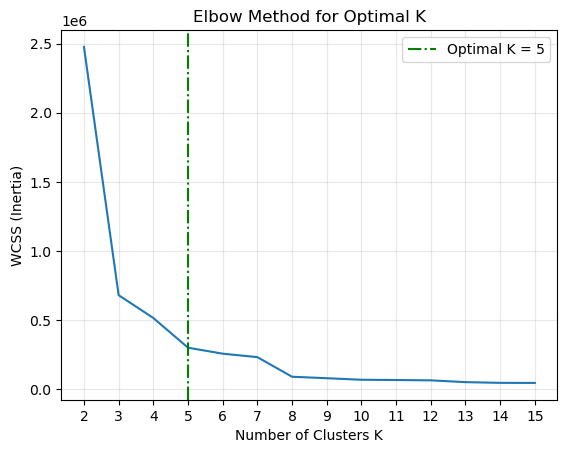

In [26]:
clustering_features_df = create_clustering_features(train_feat_df)
clustering_results = perform_clustering_exploration(clustering_features_df, K_min=2, K_max=15)
wcss_df, optimal_K = analyze_clustering_exploration(clustering_results)
plot_elbow_curve(wcss_df, optimal_K)


#### Final Clustering

In [48]:
def perform_clustering(df: DataFrame, K: int) -> DataFrame:

    ## get list of clustering feature columns (excluding series_name)
    clustering_features_list = [column for column in clustering_features_df.columns if column != "series_name"]

    # Assemble the summary features into a single vector
    kmeans_assembler = VectorAssembler(
        inputCols= clustering_features_list,
        outputCol="clustering_features"
    )

    ## Define the robust scaler object
    scaler = RobustScaler(inputCol="clustering_features",
                        outputCol="clustering_features_scaled")
    
    ## Apply the assembly transformation
    clustering_assembled_df = kmeans_assembler.transform(df)
    ## Apply the scaler transformation
    clustering_assemebled_scaled_df = scaler.fit(clustering_assembled_df).transform(clustering_assembled_df)

    # Instantiate the KMeans model
    bkmeans = BisectingKMeans(featuresCol="clustering_features", k=K, seed=42)
    # Fit the model
    kmeans_model = bkmeans.fit(clustering_assemebled_scaled_df)

    # Get the cluster assignments
    # This adds a 'prediction' column, which is the Cluster ID (0 to K-1)
    clustered_df = kmeans_model.transform(clustering_assemebled_scaled_df)
    evaluator_df = clustered_df.select("clustering_features_scaled", F.col("prediction").alias("cluster_id"))
    series_clusters = clustered_df.select("series_name", F.col("prediction").alias("cluster_id"))
    
    return series_clusters, evaluator_df, kmeans_assembler, kmeans_model

In [49]:
## Final Clustering with optimal K
series_clusters, evaluator_df, kmeans_assembler, kmeans_model = perform_clustering(clustering_features_df, optimal_K)

## Join the cluster ID back to your original full training data
## This replaces the original high-cardinality series_name
train_indexed = train_feat_df.join(series_clusters, on="series_name", how="left")
train_indexed.show(5)

## The final step is to One-Hot Encode the new 'cluster_id' column 
## (which now has only K unique values), and use that in your GBT model.

+-----------+----------+------------------+------------+--------------+----+----------+-------------------+-------------------+-----------+--------------------+--------------------+-------------------+-------------------+------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+------------------+----------+--------------------+--------------------+--------------------+-----------------------------+----------------------------+-------------------------------+------------------------------+-----------------------------+--------------------------------+----------+
|series_name| timestamp|  log_TrafficCount|TrafficCount|day_of_quarter|year|is_weekend|          month_sin|          month_cos|quarter_sin|         quarter_cos|     day_of_week_sin|    day_of_week_cos|   day_of_month_sin|  day_of_month_cos|     day_of_year_sin|    day_of_year_cos| week_of_month_sin|  week_of_month_cos|week_of_q

## Feature Selection

Cumulative Importance	

Selects the smallest number of features that cover, e.g., 90% of the total importance score.	

Recommended approach for balanced reduction and performance.

### Feature Selection Main

In [55]:
def train_feature_selection_model(train_indexed, optimal_K):

    # Define the feature columns
    features_list = [ column for column in train_indexed.columns if column not in ["series_name", "timestamp", "TrafficCount", "log_TrafficCount"]]
    features_list.append("cluster_encoded")

    # Encoding the cluster ID for each series_name
    # Define the OneHotEncoder
    cluster_encoder = OneHotEncoder(inputCol="cluster_id", outputCol="cluster_encoded", dropLast=False)

    # Define the assembler
    assembler = VectorAssembler(inputCols=features_list, outputCol="features")

    # Build the GBT model
    gbt = GBTRegressor(
        featuresCol="features", 
        labelCol="log_TrafficCount",
        maxDepth = 4,
        maxBins = optimal_K + 2,
        maxIter=100
    )

    # Build the pipeline
    pipeline = Pipeline(stages=[cluster_encoder, assembler, gbt])
    # Train the pipeline
    pipeline_model = pipeline.fit(train_indexed)
    print(f"Feature Selection Model Training Complete!")

    feature_selection_model_path = 'models/gbt_feature_selection_model_pipeline'
    pipeline_model.write().overwrite().save(feature_selection_model_path)
    print('Feature Selection Pipeline saved')
    ## Load the fitted model
    ## loaded_model = PipelineModel.load(load_path)

    return pipeline_model, features_list

In [56]:
def get_feature_importances(feature_selection_pipeline_model, features_list):
    # Access the trained GBTRegressorModel (the last stage in the pipeline)
    feature_selection_gbt_model = feature_selection_pipeline_model.stages[-1]

    # Extract and Map Feature Importances
    importances = feature_selection_gbt_model.featureImportances.toArray()
    feature_importance_map = dict(zip(features_list, importances))

    # # Create a Pandas DataFrame from the dictionary
    df_importance = pd.DataFrame.from_dict(feature_importance_map, orient='index', columns=['importance'])
    df_importance = df_importance.sort_values(by='importance', ascending=False).reset_index()
    df_importance.columns = ['feature', 'importance']

    # Calculate Cumulative Importance
    df_importance['cumulative_importance'] = df_importance['importance'].cumsum()

    ## save to csv
    df_importance.to_csv('models/gbt_model_selection_feature_importance.csv', index=False)

    return df_importance

In [57]:
def get_selected_features(importance_df: DataFrame, coverage_percent):
    ## get max cumulative importance value
    max_cumulative_importance = importance_df['cumulative_importance'].max()
    ## calculate target coverage
    target_coverage = coverage_percent * max_cumulative_importance

    # Find the point where the cumulative sum exceeds the target
    selected_features_df = importance_df[
        importance_df['cumulative_importance'] <= target_coverage
    ]

    # The index of the last feature below the target + 1 gives the count
    num_selected_features = len(selected_features_df)

    # Get the list of features to keep
    selected_feature_list = importance_df['feature'].head(num_selected_features).tolist()

    print("\n--- Feature Selection Results ---")
    print(f"Target Cumulative Coverage: {target_coverage * 100:.0f}%")
    print(f"Number of Features to keep: **{num_selected_features}** out of {len(importance_df)}")
    print(f"Actual Coverage with {num_selected_features} features: {importance_df['cumulative_importance'].iloc[num_selected_features - 1]:.3f}")

    print("\n** Final Feature List to Use for Modeling: **")
    print(selected_feature_list)
    return selected_feature_list, target_coverage

In [58]:
def plot_feature_selection(importance_df, num_selected_features, target_covereage):
    plt.figure(figsize=(10, 6))
    plt.plot(importance_df.index, importance_df['cumulative_importance'], marker='o', linestyle='-')
    plt.axhline(y=target_covereage, color='r', linestyle='--', label=f'{target_covereage*100:.0f}% Threshold')

    # Mark the selected point
    plt.axvline(x=num_selected_features, color='g', linestyle='-.', label=f'Keep {num_selected_features} Features')

    plt.title('Cumulative Feature Importance')
    plt.xlabel('Number of Features (Sorted by Importance)')
    plt.ylabel('Cumulative Importance Score')
    plt.grid(True)
    plt.legend()
    plt.show()

Feature Selection Model Training Complete!


Feature Selection Pipeline saved

--- Feature Selection Results ---
Target Cumulative Coverage: 90%
Number of Features to keep: **22** out of 31
Actual Coverage with 22 features: 0.896

** Final Feature List to Use for Modeling: **
['traffic_count_rolling_mean_7d', 'traffic_count_rolling_median_7d', 'traffic_count_rolling_mean_30d', 'traffic_count_lag_1d', 'traffic_count_rolling_std_30d', 'traffic_count_rolling_median_30d', 'cluster_id', 'traffic_count_lag_3d', 'traffic_count_rolling_std_7d', 'year', 'traffic_count_lag_7d', 'day_of_week_cos', 'week_of_year_cos', 'day_of_month_cos', 'day_of_quarter', 'week_of_quarter_cos', 'week_of_quarter_sin', 'day_of_week_sin', 'day_of_year_sin', 'week_of_year_sin', 'day_of_month_sin', 'month_sin']


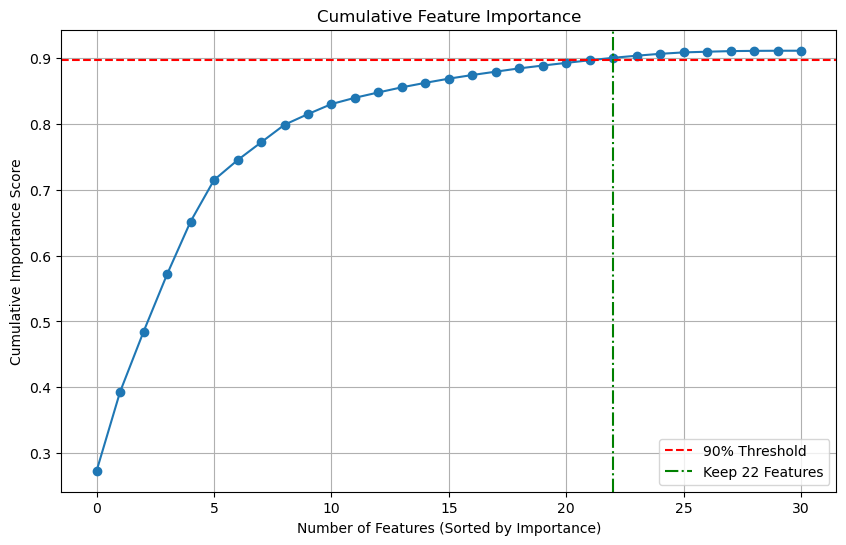

In [59]:
## Feature Selection Main
feature_selection_pipeline_model, features_list = train_feature_selection_model(train_indexed, 
                                                                                optimal_K)
feature_importance_df = get_feature_importances(feature_selection_pipeline_model, 
                                                features_list)
coverage_percent = 0.985
selected_feature_list, target_coverage = get_selected_features(feature_importance_df, 
                                                            coverage_percent)
plot_feature_selection(feature_importance_df,
                        num_selected_features=len(selected_feature_list), 
                        target_covereage= target_coverage)

### Feature Selection Validation

Our next step is to validate the benefit of feature selection by comparing the performance of the full-feature model against a new, feature-optimized model.

The goal is to prove that the simpler model—using only the top X features—achieves nearly identical, or sometimes even better, performance than the complex model, while being faster to train and less prone to overfitting.

In [60]:
def get_cv_dates(df, date_col="timestamp", num_folds=5):
    """
    Get cross-validation dates for time series data.

    Args:
        df (pyspark.sql.dataframe.DataFrame): The input DataFrame.
        date_col (str): The name of the date column.
        num_folds (int): The number of folds for cross-validation.

    Returns:
        list: A list of dates for cross-validation.
    """
    # Define the start date for the first validation window
    start_validation_date = df.select(F.min(date_col)).collect()[0][0]
    # Use the max date of the training set as the final limit
    max_train_date = df.select(F.max(date_col)).collect()[0][0]
    ### Define the interval in days that each CV fold will cover
    interval_days = math.floor((max_train_date - start_validation_date).days/num_folds)
    ## create a list of 5 dates starting from start_validation_date that are interval days apart
    cv_dates = [start_validation_date + relativedelta(days = interval_days*i) for i in range(num_folds)]
    ## append the last date as max_train_date minus 1 month to ensure full final validation data
    cv_dates.append(max_train_date - relativedelta(months=1))

    return cv_dates

In [61]:
def get_clusters(kmeans_model, assembler, df: DataFrame) -> DataFrame:
    # Get the cluster assignments
    # This adds a 'prediction' column, which is the Cluster ID (0 to K-1)
    clustered_df = kmeans_model.transform(assembler.transform(df))
    series_clusters = clustered_df.select("series_name", F.col("prediction").alias("cluster_id"))
    return series_clusters

In [95]:
def build_clustering_pipeline(df, K):

    ## get list of clustering feature columns (excluding series_name)
    clustering_features_list = [column for column in df.columns if column != "series_name"]

    ## Assemble the summary features into a single vector
    kmeans_assembler = VectorAssembler(
            inputCols=clustering_features_list,
            outputCol="clustering_features"
        )

    ## Fit the KMeans model
    kmeans_model = BisectingKMeans(k=K,
                                    featuresCol="clustering_features",
                                    predictionCol="cluster_id",
                                    seed=42)
    
    ## compile the pipeline
    clustering_pipeline = Pipeline(stages=[kmeans_assembler, kmeans_model])
    return clustering_pipeline

def build_regression_pipeline(estimator, feature_list: list):

    # Add a guard clause for the estimator
    if estimator is None:
        raise ValueError("The estimator (model) passed to build_regression_pipeline cannot be None.")
    
    # Indexing/Encoding: For categorical features like 'cluster_id' and 'series_name'
    cluster_encoder = OneHotEncoder(inputCol="cluster_id", outputCol="cluster_encoded", dropLast=False)
    
    # Feature Assembly: Assembles all final features (numeric + OHE vectors)
    # The feature_list should include your features, plus "cluster_encoded"
    final_features_list = feature_list + ["cluster_encoded"]
    assembler = VectorAssembler(inputCols=final_features_list, outputCol="features")

    ## Define the robust scaler object
    scaler = RobustScaler(inputCol="features",
                        outputCol="features_scaled")
    
    # Add an assertion or check for each stage just to be safe (though less likely)
    if any(stage is None for stage in [cluster_encoder, assembler, scaler]):
        raise ValueError("One of the pipeline transformation stages is None.")
    
    ## compile the pipeline
    regression_pipeline = Pipeline(stages=[cluster_encoder, assembler, scaler, estimator])
    return regression_pipeline

In [63]:
def walk_forward_cross_validation_with_data_prep(df: DataFrame, model, feature_list, evaluator, num_folds: int = 5):
    """
    Perform walk-forward cross-validation on time series data.

    Args:
        df (pyspark.sql.dataframe.DataFrame): The training DataFrame with features and label.
        model: The machine learning model to be evaluated.
    """
    ## Get the Cross Validation dates
    cv_dates = get_cv_dates(df, date_col="timestamp", num_folds= num_folds)

    ## Initialize list to collect MAE for each fold
    mae_list = []

    ## iterate through each date-based fold
    for i in range(len(cv_dates)-1):

        ## define start and end dates for training and validation
        training_start_date = cv_dates[0]
        training_end_date = cv_dates[i+1]
        validation_start_date = training_end_date ## training end date is also the validation start date
        validation_end_date = validation_start_date + relativedelta(months=1) ## validation data is 1 month
        print(f"Fold {i+1}: Training starts {training_start_date}, Training ends {training_end_date}, Validation ends {validation_end_date}")
        
        # Split the train/validation data for this Fold
        cv_train = df.filter( 
            (F.col("timestamp") > training_start_date) & 
            (F.col("timestamp") < training_end_date)
            )
        cv_validation = df.filter(
            (F.col("timestamp") >= validation_start_date) & 
            (F.col("timestamp") < validation_end_date)
        )

        ####################################################
        ## perform clustering and get cluster assignments ##
        ####################################################

        ## Get clustering features on training data
        train_cluster_feat = create_clustering_features(cv_train)
        ## get clustering pipeline
        clustering_pipeline = build_clustering_pipeline(train_cluster_feat, 
                                                        optimal_K)
        ## train clustering pipeline
        clustering_model = clustering_pipeline.fit(train_cluster_feat)
        ## get clusters for training data
        train_clusters = clustering_model.transform(train_cluster_feat)
        ## join clusters back to training data
        fold_train_cluster = cv_train.join(train_clusters,
                                    on="series_name",
                                    how="left")

        ## Get clustering features on validation data
        validation_cluster_feat = create_clustering_features(cv_validation)
        ## get clusters for validation data
        validation_clusters = clustering_model.transform(validation_cluster_feat)
        ## join clusters back to validation data
        fold_validation_cluster = cv_validation.join(validation_clusters, 
                                                    on="series_name", 
                                                    how="left")

        #############################################
        ## Run the modeling pipeline for this fold ##
        #############################################

        ## perform the assembly and pipeline transformations to get the final features for modeling
        pipeline = build_regression_pipeline(model,feature_list)
        ## Train the pipeline on the training fold
        fitted_pipeline = pipeline.fit(fold_train_cluster)
        ## Generate predictions from validation fold
        predictions = fitted_pipeline.transform(fold_validation_cluster)
        ## Evaluate the predictions
        mae = evaluator.evaluate(predictions)
        mae_list.append(mae)

        print(f"Fold {i+1} completed.")

    # Calculate average MAE across all folds
    average_mae = sum(mae_list) / len(mae_list)
    
    return average_mae, mae_list

In [70]:
def get_feature_validation_results(feature_validation_results, selected_feature_list):
    mae_full = feature_validation_results['GBT_full']
    mae_optimized = feature_validation_results['GBT_optimized']

    print(f"Full Features Model MAE: {mae_full}")
    print(f"Optimized Features Model MAE: {mae_optimized}")

    mae_diff = mae_full - mae_optimized
    print(f"MAE Difference: {mae_diff}")

    # Calculate the percentage difference
    percentage_diff = (mae_diff / mae_full) * 100
    print(f"Percentage Difference: {percentage_diff:.2f}%")

    ###################################
    ### Feature Selection Conclusion ##
    ###################################
    count_selected_features = len(selected_feature_list)
    direction = "increase" if mae_diff > 0 else "decrease"
    opt_worthwhile = "is" if (mae_diff < 2) or (percentage_diff < 5) else "is not"
    text2 = f"The performance {direction} from dropping to the top {count_selected_features} features shows that it {opt_worthwhile} worthwhile to shift to only these {count_selected_features} features."
    print(text2)

    full_feature_bool = True
    if opt_worthwhile == "is":
        full_feature_bool = False
        conclusion_text = f"""CONCLUSION: We will proceed with using only the top {count_selected_features} features."""
    else:
        conclusion_text = f"""CONCLUSION: We will proceed with using the full feature list."""
    print(conclusion_text)

    return full_feature_bool

In [ ]:
## define the MAE evaluator
MAE_EVALUATOR = RegressionEvaluator(
    labelCol='TrafficCount', 
    predictionCol="regression_prediction", 
    metricName="mae"
)

## Define the GBT model for evaluation
gbt = GBTRegressor(
    featuresCol="features", 
    labelCol="TrafficCount", 
    maxDepth=4, 
    maxBins= optimal_K +2,
    maxIter=100
)

feature_validation_models = {
    "GBT_optimized": gbt.copy(),
    "GBT_full": gbt.copy()
}

In [65]:
## initialize the results dictionary
feature_validation_results = {}

## Iterate through each model
for name, model in feature_validation_models.items():
    print(f"\n--- Evaluating Model: {name} ---")
    
    if name == "GBT_optimized":
        feature_list = selected_feature_list
    elif name == "GBT_full":
        feature_list = features_list

    ## set the prediction column to a unique name to avoid conflicts
    model = model.setPredictionCol("regression_prediction")

    ## Perform walk-forward cross-validation
    avg_mae, mae_list = walk_forward_cross_validation_with_data_prep(df= train_feat_df, 
                                                                    model= model, 
                                                                    feature_list= feature_list,
                                                                    evaluator= MAE_EVALUATOR,
                                                                    num_folds= 5)

    # Store the result
    feature_validation_results[name] = avg_mae

    print(f'{name} complete!')
    
print("\n--- Model Comparison Results (MAE) ---")
for name, mae in sorted(feature_validation_results.items(), key=lambda item: item[1]):
    print(f"{name}: {mae:.4f}")


--- Evaluating Model: GBT_optimized ---
Fold 1: Training starts 2015-07-01, Training ends 2015-11-19, Validation ends 2015-12-19


Fold 1 completed.
Fold 2: Training starts 2015-07-01, Training ends 2016-04-08, Validation ends 2016-05-08


Fold 2 completed.
Fold 3: Training starts 2015-07-01, Training ends 2016-08-27, Validation ends 2016-09-27


Fold 3 completed.
Fold 4: Training starts 2015-07-01, Training ends 2017-01-15, Validation ends 2017-02-15


Fold 4 completed.
Fold 5: Training starts 2015-07-01, Training ends 2017-05-09, Validation ends 2017-06-09


Fold 5 completed.
GBT_optimized complete!

--- Evaluating Model: GBT_full ---
Fold 1: Training starts 2015-07-01, Training ends 2015-11-19, Validation ends 2015-12-19


Fold 1 completed.
Fold 2: Training starts 2015-07-01, Training ends 2016-04-08, Validation ends 2016-05-08


Fold 2 completed.
Fold 3: Training starts 2015-07-01, Training ends 2016-08-27, Validation ends 2016-09-27


Fold 3 completed.
Fold 4: Training starts 2015-07-01, Training ends 2017-01-15, Validation ends 2017-02-15


Fold 4 completed.
Fold 5: Training starts 2015-07-01, Training ends 2017-05-09, Validation ends 2017-06-09


Fold 5 completed.
GBT_full complete!

--- Model Comparison Results (MAE) ---
GBT_full: 15.4591
GBT_optimized: 15.5939


In [71]:
full_feature_bool = get_feature_validation_results(feature_validation_results, selected_feature_list)

if full_feature_bool:
    print('\nFull Feature List Selected')
    feature_list = features_list
else:
    print('\nOptimized Feature List Selected')
    feature_list = selected_feature_list

Full Features Model MAE: 15.459116020929258
Optimized Features Model MAE: 15.593892512202036
MAE Difference: -0.13477649127277758
Percentage Difference: -0.87%
The performance decrease from dropping to the top 22 features shows that it is worthwhile to shift to only these 22 features.
CONCLUSION: We will proceed with using only the top 22 features.

Optimized Feature List Selected


## Model Selection

We will compare the performance of the following models: 
* Linear Regressor (baseline model)
* Gradient Boost Trees Regressor
* Random Forest Regressor
* XGBoost Regressor

Each of these models has either native or third party PySpark support in order to take advantage of PySpark's scalability for machine learning.

In [77]:
## Shared configuration
LABEL_COL = "log_TrafficCount"
FEATURES_COL = "features"
PREDICTION_COL = "regression_prediction"
max_iter = 30
n_estimators = 100
seed = 42
max_bins = 32
max_depth = 5

MAE_EVALUATOR = RegressionEvaluator(
    labelCol=LABEL_COL, 
    predictionCol= PREDICTION_COL, 
    metricName="mae"
)

## Linear Regression (Base Model)
lr = LinearRegression(
    featuresCol=FEATURES_COL, 
    labelCol=LABEL_COL,
    predictionCol = PREDICTION_COL, 
    maxIter=max_iter,
    elasticNetParam= 1.0,
    regParam = 1.0
)

## Random Forest
rf = RandomForestRegressor(
    featuresCol=FEATURES_COL, 
    labelCol=LABEL_COL,
    predictionCol = PREDICTION_COL, 
    numTrees= max_iter,
    maxBins = max_bins,
    maxDepth = max_depth,
    seed = seed
)

## Gradient Boosted Trees
gbt = GBTRegressor(
    featuresCol=FEATURES_COL, 
    labelCol=LABEL_COL,
    predictionCol = PREDICTION_COL,  
    maxIter= max_iter,
    maxDepth= max_depth,
    maxBins = max_bins,
    seed = seed
)

## XGBoost
xgb = SparkXGBRegressor(
    features_col=FEATURES_COL, 
    label_col=LABEL_COL,
    prediction_col= "regression_prediction",
    n_estimators= n_estimators,
    max_depth= max_depth,
    maxBins = max_bins,
    learning_rate = 0.1,
    objective = "reg:squarederror",
    seed = seed,
    eval_metric = 'mae',
    verbosity=0
)

model_selection_models = {
    "XGBoost": xgb,
    "Linear Regression": lr,
    "Random Forest": rf,
    "GBT": gbt
}

In [78]:
model_selection_results = {}

## Iterate through each model
for name, model in model_selection_models.items():
    print(f"\n--- Evaluating Model: {name} ---")

    if name != "XGBoost":
        ## set the prediction column to a unique name to avoid conflicts
        model = model.setPredictionCol("regression_prediction")

    ## Perform walk-forward cross-validation
    avg_mae, mae_list = walk_forward_cross_validation_with_data_prep(df= train_feat_df, 
                                                                    model= model, 
                                                                    feature_list= feature_list,
                                                                    evaluator= MAE_EVALUATOR,
                                                                    num_folds= 5)

    # Store the result
    model_selection_results[name] = avg_mae

    print(f'{name} complete!')

print("\n--- Model Comparison Results (MAE) ---")
for name, mae in sorted(model_selection_results.items(), key=lambda item: item[1]):
    print(f"{name}: {mae:.4f}")


--- Evaluating Model: XGBoost ---
Fold 1: Training starts 2015-07-01, Training ends 2015-11-19, Validation ends 2015-12-19


INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with       (2 + 8) / 10]
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'eval_metric': 'mae', 'learning_rate': 0.1, 'max_depth': 5, 'verbosity': 0, 'maxBins': 32, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 14:21:24,588 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[14:21:25] Task 0 got rank 0
[14:21:26] [0]	training-mae:0.65565
[14:21:26] [1]	training-mae:0.62616
[14:21:26] [2]	training-mae:0.60094
[14:21:26] [3]	training-mae:0.57928
[14:21:26] [4]	training-mae:0.56066
[14:21:26] [5]	training-mae:0.54486
[14:21:26] [6]	training-mae:0.53141
[14:21:26] [7]	training-mae:0.51989
[14:21:26] [8]	training-mae:0.51001
[14:21:26] [9]	training-mae:0.50147
[14:21:26] [10]	training-mae:0.49406
[14:21:26] [11]	training-mae:0.48774
[14:21:26] [12]	training-mae:0.48251
[14:21:26] [13]	training-mae:0.

Fold 1 completed.
Fold 2: Training starts 2015-07-01, Training ends 2016-04-08, Validation ends 2016-05-08


INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with       (5 + 5) / 10]
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'eval_metric': 'mae', 'learning_rate': 0.1, 'max_depth': 5, 'verbosity': 0, 'maxBins': 32, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 14:23:37,069 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[14:23:38] Task 0 got rank 0
[14:23:39] [0]	training-mae:0.66055
[14:23:39] [1]	training-mae:0.62565
[14:23:39] [2]	training-mae:0.59560
[14:23:39] [3]	training-mae:0.56971
[14:23:39] [4]	training-mae:0.54765
[14:23:39] [5]	training-mae:0.52879
[14:23:39] [6]	training-mae:0.51274
[14:23:39] [7]	training-mae:0.49904
[14:23:39] [8]	training-mae:0.48730
[14:23:39] [9]	training-mae:0.47745
[14:23:39] [10]	training-mae:0.46900
[14:23:39] [11]	training-mae:0.46176
[14:23:39] [12]	training-mae:0.45557
[14:23:39] [13]	training-mae:0.

Fold 2 completed.
Fold 3: Training starts 2015-07-01, Training ends 2016-08-27, Validation ends 2016-09-27


INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with       (4 + 6) / 10]
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'eval_metric': 'mae', 'learning_rate': 0.1, 'max_depth': 5, 'verbosity': 0, 'maxBins': 32, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 14:25:45,608 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[14:25:46] Task 0 got rank 0
[14:25:48] [0]	training-mae:0.64564
[14:25:48] [1]	training-mae:0.60952
[14:25:48] [2]	training-mae:0.57831
[14:25:48] [3]	training-mae:0.55147
[14:25:48] [4]	training-mae:0.52846
[14:25:49] [5]	training-mae:0.50884
[14:25:49] [6]	training-mae:0.49221
[14:25:49] [7]	training-mae:0.47807
[14:25:49] [8]	training-mae:0.46602
[14:25:49] [9]	training-mae:0.45592
[14:25:49] [10]	training-mae:0.44742
[14:25:49] [11]	training-mae:0.44015
[14:25:49] [12]	training-mae:0.43396
[14:25:49] [13]	training-mae:0.

Fold 3 completed.
Fold 4: Training starts 2015-07-01, Training ends 2017-01-15, Validation ends 2017-02-15


INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with       (6 + 4) / 10]
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'eval_metric': 'mae', 'learning_rate': 0.1, 'max_depth': 5, 'verbosity': 0, 'maxBins': 32, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 14:28:04,719 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[14:28:05] Task 0 got rank 0
[14:28:08] [0]	training-mae:0.63048
[14:28:08] [1]	training-mae:0.59552
[14:28:08] [2]	training-mae:0.56536
[14:28:08] [3]	training-mae:0.53941
[14:28:08] [4]	training-mae:0.51722
[14:28:08] [5]	training-mae:0.49839
[14:28:08] [6]	training-mae:0.48234
[14:28:08] [7]	training-mae:0.46874
[14:28:08] [8]	training-mae:0.45726
[14:28:08] [9]	training-mae:0.44748
[14:28:09] [10]	training-mae:0.43920
[14:28:09] [11]	training-mae:0.43223
[14:28:09] [12]	training-mae:0.42638
[14:28:09] [13]	training-mae:0.

Fold 4 completed.
Fold 5: Training starts 2015-07-01, Training ends 2017-05-09, Validation ends 2017-06-09


INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with       (5 + 5) / 10]
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'eval_metric': 'mae', 'learning_rate': 0.1, 'max_depth': 5, 'verbosity': 0, 'maxBins': 32, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 14:30:25,491 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[14:30:26] Task 0 got rank 0
[14:30:29] [0]	training-mae:0.63172
[14:30:29] [1]	training-mae:0.59566
[14:30:29] [2]	training-mae:0.56469
[14:30:29] [3]	training-mae:0.53808
[14:30:30] [4]	training-mae:0.51531
[14:30:30] [5]	training-mae:0.49578
[14:30:30] [6]	training-mae:0.47925
[14:30:30] [7]	training-mae:0.46531
[14:30:30] [8]	training-mae:0.45350
[14:30:30] [9]	training-mae:0.44353
[14:30:30] [10]	training-mae:0.43506
[14:30:30] [11]	training-mae:0.42794
[14:30:30] [12]	training-mae:0.42193
[14:30:30] [13]	training-mae:0.

Fold 5 completed.
XGBoost complete!

--- Evaluating Model: Linear Regression ---


Fold 1: Training starts 2015-07-01, Training ends 2015-11-19, Validation ends 2015-12-19


Fold 1 completed.
Fold 2: Training starts 2015-07-01, Training ends 2016-04-08, Validation ends 2016-05-08


Fold 2 completed.
Fold 3: Training starts 2015-07-01, Training ends 2016-08-27, Validation ends 2016-09-27


Fold 3 completed.
Fold 4: Training starts 2015-07-01, Training ends 2017-01-15, Validation ends 2017-02-15


Fold 4 completed.
Fold 5: Training starts 2015-07-01, Training ends 2017-05-09, Validation ends 2017-06-09


Fold 5 completed.
Linear Regression complete!

--- Evaluating Model: Random Forest ---
Fold 1: Training starts 2015-07-01, Training ends 2015-11-19, Validation ends 2015-12-19


Fold 1 completed.
Fold 2: Training starts 2015-07-01, Training ends 2016-04-08, Validation ends 2016-05-08


Fold 2 completed.
Fold 3: Training starts 2015-07-01, Training ends 2016-08-27, Validation ends 2016-09-27


Fold 3 completed.
Fold 4: Training starts 2015-07-01, Training ends 2017-01-15, Validation ends 2017-02-15


Fold 4 completed.
Fold 5: Training starts 2015-07-01, Training ends 2017-05-09, Validation ends 2017-06-09


Fold 5 completed.
Random Forest complete!

--- Evaluating Model: GBT ---
Fold 1: Training starts 2015-07-01, Training ends 2015-11-19, Validation ends 2015-12-19


Fold 1 completed.
Fold 2: Training starts 2015-07-01, Training ends 2016-04-08, Validation ends 2016-05-08


Fold 2 completed.
Fold 3: Training starts 2015-07-01, Training ends 2016-08-27, Validation ends 2016-09-27


Fold 3 completed.
Fold 4: Training starts 2015-07-01, Training ends 2017-01-15, Validation ends 2017-02-15


Fold 4 completed.
Fold 5: Training starts 2015-07-01, Training ends 2017-05-09, Validation ends 2017-06-09


Fold 5 completed.
GBT complete!

--- Model Comparison Results (MAE) ---
XGBoost: 0.3842
Random Forest: 0.3860
GBT: 0.3896
Linear Regression: 0.6497


In [79]:
model_selection_results_df = pd.DataFrame.from_dict(model_selection_results, orient='index', columns=['MAE']).reset_index()
model_selection_results_df.columns = ['Model', 'MAE']
model_selection_results_df = model_selection_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)
model_selection_results_df

,Model,MAE
0,XGBoost,0.384183
1,Random Forest,0.385970
2,GBT,0.389559
3,Linear Regression,0.649746


### Model Comparison Results

The fact that Linear Regression outperforms the high-capacity, non-linear models like XGBoost, Random Forest, and GBT has a key implication:

Signal Simplicity: The engineered features (lags, rolling averages, time features) have likely captured the primary underlying signal of the traffic data well enough that the relationship between the features and the target is close to linear.

Overfitting Avoidance: The tree-based models, despite their power, seem to be prone to overfitting the noise in the individual training folds, resulting in worse out-of-sample performance (higher MAE) compared to the inherently simpler, highly regularized Linear Regression model.

We will proceed with the Linear Regression Model.

## Hyperparameter Tuning

I select the SparkXGBRegressor as my primary model for its robustness and performance with structured data. To find the optimal hyperparameters, I employ Bayesian Optimization (Hyperopt) over a computationally expensive grid search, saving significant compute time.

In [ ]:
## Select the best model based on lowest MAE
chosen_model = model_selection_results_df.sort_values(by='MAE', ascending=True).iloc[0]['Model']

## check which model had the lowest MAE and define it for final training
if chosen_model == 'XGBoost':
    print("Proceeding with XGBoostRegressor as the chosen model.")
    # Define the XGBoost Model (using the features from your Assembler)
    model = SparkXGBRegressor(
        features_col="features", 
        label_col="log_TrafficCount",
        prediction_col= 'regression_prediction',
        verbosity = 0,
        eval_metric = "mae"
    )

    search_space = {
        ## Tree Depth (Integer)
        'maxDepth': hp.quniform('maxDepth', 5, 12, 1), # Search integers 5, 6, 7, ..., 12
        ## Number of Trees (Integer)
        'maxIter': hp.quniform('maxIter', 100, 800, 50), # Search integers 100, 150, ..., 600
        ## Learning Rate (Float, Logarithmic Scale)
        'learningRate': hp.loguniform('learningRate', np.log(0.01), np.log(0.3)),
        ## Regularization (Minimum Loss Reduction)
        ## specifies the minimum loss reduction required to make a further split on a leaf node. 
        ## Higher values (e.g., > 1.0) make the model more conservative.
        'min_split_loss': hp.loguniform('min_split_loss', np.log(0.01), np.log(5.0))
    }

elif chosen_model == 'GBT':
    print("Proceeding with GradientBoostTrees as the chosen model.")
    model = GBTRegressor(
        featuresCol="features",
        labelCol="TrafficCount"
    )
    model = model.setPredictionCol("regression_prediction")

elif chosen_model == 'Random Forest':
    print("Proceeding with Random Forest as the chosen model.")
    model = RandomForestRegressor(
        featuresCol="features",
        labelCol="TrafficCount"
    )
    model = model.setPredictionCol("regression_prediction")

elif chosen_model == 'Linear Regression':
    print("Proceeding with Linear Regression as the chosen model.")
    model = LinearRegression(
        featuresCol="features",
        labelCol="TrafficCount"
        )
    model = model.setPredictionCol("regression_prediction")
    # Define the Parameter Grid to Search
    param_grid = (ParamGridBuilder()
        # regParam (λ): The regularization parameter. Higher values mean stronger regularization.
        .addGrid(model.regParam, [0.01, 0.1, 1.0])
        # elasticNetParam (α): Controls the balance between L1 (Lasso) and L2 (Ridge).
        # 0.0 = Ridge (L2 only) - 0.5 = Elastic Net (mix) -  1.0 = Lasso (L1 only)
        .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0])
        # Add a range for max iterations, useful if convergence is an issue.
        .addGrid(model.maxIter, [100, 200])
        .build())

Proceeding with XGBoostRegressor as the chosen model.


In [ ]:
def walk_forward_objective(
    hyperparams,
    df: DataFrame,
    base_model, # <-- accepts the instantiated PySpark Estimator OBJECT
    feature_list,
    evaluator,
    num_folds: int = 5
):
    """
    The Objective Function for hyperopt. It evaluates a single set of hyperparameters 
    using walk-forward cross-validation and returns the mean MAE.
    
    Args:
        hyperparams (dict): A dictionary of hyperparameters provided by hyperopt.
        df (DataFrame): The full training DataFrame.
        base_model (Estimator): The *instantiated* PySpark Estimator object (e.g., SparkXGBRegressor(...)).
        feature_list (list): List of features for the regression pipeline.
        evaluator (RegressionEvaluator): The PySpark evaluator instance.
        num_folds (int): Number of walk-forward folds to perform.
        
    Returns:
        dict: A dictionary containing the loss (MAE) and optimization status.
    """
    
    ## Instantiate the Model with Hyperopt Parameters (using .copy() and .setParams())
    
    ## Create a copy of the base model object
    current_model = base_model.copy()
    
    ## Setup Cross-Validation
    cv_dates = get_cv_dates(df, date_col="timestamp", num_folds=num_folds)
    mae_list = []
    
    ## Iterate through each date-based fold (Fold logic is preserved)
    for i in range(len(cv_dates)-1):
        
        ## Define train/validation windows
        training_start_date = cv_dates[0]
        training_end_date = cv_dates[i+1]
        validation_start_date = training_end_date
        validation_end_date = validation_start_date + relativedelta(months=1)

        ## Split the data
        cv_train = df.filter((F.col("timestamp") > training_start_date) & (F.col("timestamp") < training_end_date))
        cv_validation = df.filter((F.col("timestamp") >= validation_start_date) & (F.col("timestamp") < validation_end_date))

        ## --- Clustering/Feature Prep for the Fold (MUST be done inside the loop) ---
        train_cluster_feat = create_clustering_features(cv_train)
        clustering_pipeline = build_clustering_pipeline(train_cluster_feat, optimal_K)
        clustering_model = clustering_pipeline.fit(train_cluster_feat)
        train_clusters = clustering_model.transform(train_cluster_feat)
        fold_train_cluster = cv_train.join(train_clusters, on="series_name", how="left")

        validation_cluster_feat = create_clustering_features(cv_validation)
        validation_clusters = clustering_model.transform(validation_cluster_feat)
        fold_validation_cluster = cv_validation.join(validation_clusters, on="series_name", how="left")
        
        ## --- Run Modeling Pipeline ---
        pipeline = build_regression_pipeline(current_model, feature_list)
        fitted_pipeline = pipeline.fit(fold_train_cluster)
        predictions = fitted_pipeline.transform(fold_validation_cluster)
        mae = evaluator.evaluate(predictions)
        mae_list.append(mae)

    ## Calculate Final Loss and Return to hyperopt
    mean_mae = np.mean(mae_list)
    
    return {
        'loss': mean_mae,  # hyperopt minimizes the 'loss' key
        'status': STATUS_OK,
        'params': hyperparams
    }

def bayesian_tuning_executor_with_early_stopping(
    df: DataFrame, 
    base_model, # <-- accepts the instantiated PySpark Estimator OBJECT
    feature_list, 
    evaluator, 
    search_space, 
    max_evals: int = 30, ## Set an upper limit
    num_folds: int = 5,
    patience: int = 10 ## Number of non-improving iterations allowed
):
    """
    Initializes and runs the hyperopt search with an Early Stopping mechanism.
    """
    
    trials = Trials()
    f_wrapper = lambda h: walk_forward_objective(h, df, base_model, feature_list, evaluator, num_folds)
    
    print(f"Starting Bayesian Optimization (Max: {max_evals} evals, Patience: {patience})...")
    
    best_loss = float('inf')
    best_loss_iteration = 0
    non_improving_count = 0
    
    ## --- Custom Loop for Early Stopping ---
    
    for iteration in range(1, max_evals + 1):
        
        ## Run the next evaluation step
        best_params = fmin(
            fn=f_wrapper,
            space=search_space,
            algo=tpe.suggest,
            max_evals=iteration, ## Incrementally run fmin to track progress
            trials=trials
        )
        
        ## Get the current best loss
        current_best_loss = trials.best_trial['result']['loss']
        
        print(f"Iteration {iteration}/{max_evals}: Current Best MAE = {current_best_loss:.4f}")

        ## Check for Improvement and Apply Patience
        if current_best_loss < best_loss:
            ## Improvement found
            best_loss = current_best_loss
            best_loss_iteration = iteration
            non_improving_count = 0 # Reset counter
        else:
            ## No improvement
            non_improving_count += 1
        
        ## Check Stopping Condition
        if non_improving_count >= patience:
            print(f"\n🛑 **Early Stopping Triggered** at iteration {iteration}!")
            print(f"No improvement for {patience} iterations. Best MAE found in iteration {best_loss_iteration}.")
            break
            
    ## --- End of Loop ---
    
    ## Final Results
    print("\n--- Bayesian Optimization Results ---")
    print(f"Best Loss (Mean Walk-Forward MAE): {best_loss:.4f}")
    
    # ## We retrieve the actual best params from the trials object
    # final_best_params = trials.best_trial['misc']['vals']
    ## The 'fmin' result (best_params) is slightly cleaner for final output:
    print(f"Best Hyperparameters (hyperopt format): {best_params}")
    
    return best_params, best_loss

In [150]:
## Shared configuration
LABEL_COL = "log_TrafficCount"
FEATURES_COL = "features"
PREDICTION_COL = "regression_prediction"

MAE_EVALUATOR = RegressionEvaluator(
    labelCol=LABEL_COL, 
    predictionCol= PREDICTION_COL, 
    metricName="mae"
)

In [ ]:
## Run  Bayesian Optimization
best_params, best_mae = bayesian_tuning_executor_with_early_stopping(
    df= train_feat_df,
    base_model= model,
    feature_list= feature_list,
    evaluator= MAE_EVALUATOR,
    search_space= search_space,
    max_evals= 30, # Significantly fewer evaluations than exhaustive search
    num_folds= 5, ## cross validation fold count
    patience = 10 ## early stopping after X evaluations with no improvement
)

Starting Bayesian Optimization (Max: 20 evals, Patience: 5)...
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with       (4 + 6) / 10]
	booster params: {'device': 'cpu', 'eval_metric': 'mae', 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 16:39:41,190 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[16:39:42] Task 0 got rank 0
[16:39:42] [0]	training-mae:0.59057
[16:39:42] [1]	training-mae:0.53195
[16:39:42] [2]	training-mae:0.49743
[16:39:42] [3]	training-mae:0.47715
[16:39:42] [4]	training-mae:0.46482
[16:39:42] [5]	training-mae:0.45725
[16:39:43] [6]	training-mae:0.45263
[16:39:43] [7]	training-mae:0.44962
[16:39:43] [8]	training-mae:0.44667
[16:39:43] [9]	training-mae:0.44471
[16:39:43] [10]	training-mae:0.44314
[16:39:43] [11]	training-mae:0.44223
[16:39:43] [12]	training-mae:0.44130
[16:39:43] [13]	training-mae:0.44045
[16:39:43] [14]	training-mae:0.43950
[16:39:43] [15]	traini

100%|██████████| 1/1 [13:00<00:00, 780.13s/trial, best loss: 0.3899445284707255]
Iteration 1/20: Current Best MAE = 0.3899
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with       (4 + 6) / 10]
	booster params: {'device': 'cpu', 'eval_metric': 'mae', 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 16:52:01,095 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[16:52:02] Task 0 got rank 0
[16:52:02] [0]	training-mae:0.59057
[16:52:02] [1]	training-mae:0.53195
[16:52:02] [2]	training-mae:0.49743
[16:52:02] [3]	training-mae:0.47715
[16:52:02] [4]	training-mae:0.46482
[16:52:02] [5]	training-mae:0.45725
[16:52:02] [6]	training-mae:0.45263
[16:52:02] [7]	training-mae:0.44962
[16:52:02] [8]	training-mae:0.44667
[16:52:02] [9]	training-mae:0.44471
[16:52:02] [10]	training-mae:0.44314
[16:52:03] [11]	training-mae:0.44223
[16:52:03] [12]	training-mae:0.44130
[16:52:03] [13]	training-mae:0.44045
[16:52:03] [14]	training-mae:0.43950
[16:52:03] [15]	traini

100%|██████████| 2/2 [11:32<00:00, 692.81s/trial, best loss: 0.3899445284707255]
Iteration 2/20: Current Best MAE = 0.3899
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with       (7 + 3) / 10]
	booster params: {'device': 'cpu', 'eval_metric': 'mae', 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 17:04:13,963 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[17:04:14] Task 0 got rank 0
[17:04:15] [0]	training-mae:0.59057
[17:04:15] [1]	training-mae:0.53195
[17:04:15] [2]	training-mae:0.49743
[17:04:15] [3]	training-mae:0.47715
[17:04:15] [4]	training-mae:0.46482
[17:04:15] [5]	training-mae:0.45725
[17:04:15] [6]	training-mae:0.45263
[17:04:15] [7]	training-mae:0.44962
[17:04:15] [8]	training-mae:0.44667
[17:04:15] [9]	training-mae:0.44471
[17:04:15] [10]	training-mae:0.44314
[17:04:15] [11]	training-mae:0.44223
[17:04:15] [12]	training-mae:0.44130
[17:04:15] [13]	training-mae:0.44045
[17:04:15] [14]	training-mae:0.43950
[17:04:15] [15]	traini

100%|██████████| 3/3 [13:46<00:00, 826.37s/trial, best loss: 0.3899445284707255]
Iteration 3/20: Current Best MAE = 0.3899
 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with       (4 + 6) / 10]
	booster params: {'device': 'cpu', 'eval_metric': 'mae', 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 17:17:56,975 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[17:17:58] Task 0 got rank 0
[17:17:58] [0]	training-mae:0.59057
[17:17:58] [1]	training-mae:0.53195
[17:17:58] [2]	training-mae:0.49743
[17:17:58] [3]	training-mae:0.47715
[17:17:58] [4]	training-mae:0.46482
[17:17:58] [5]	training-mae:0.45725
[17:17:58] [6]	training-mae:0.45263
[17:17:58] [7]	training-mae:0.44962
[17:17:58] [8]	training-mae:0.44667
[17:17:58] [9]	training-mae:0.44471
[17:17:58] [10]	training-mae:0.44314
[17:17:58] [11]	training-mae:0.44223
[17:17:58] [12]	training-mae:0.44130
[17:17:58] [13]	training-mae:0.44045
[17:17:58] [14]	training-mae:0.43950
[17:17:58] [15]	traini

100%|██████████| 4/4 [13:10<00:00, 790.89s/trial, best loss: 0.3899445284707255]
Iteration 4/20: Current Best MAE = 0.3899
 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with       (6 + 4) / 10]
	booster params: {'device': 'cpu', 'eval_metric': 'mae', 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 17:31:15,657 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[17:31:16] Task 0 got rank 0
[17:31:17] [0]	training-mae:0.59057
[17:31:17] [1]	training-mae:0.53195
[17:31:17] [2]	training-mae:0.49743
[17:31:17] [3]	training-mae:0.47715
[17:31:17] [4]	training-mae:0.46482
[17:31:17] [5]	training-mae:0.45725
[17:31:17] [6]	training-mae:0.45263
[17:31:17] [7]	training-mae:0.44962
[17:31:17] [8]	training-mae:0.44667
[17:31:17] [9]	training-mae:0.44471
[17:31:17] [10]	training-mae:0.44314
[17:31:17] [11]	training-mae:0.44223
[17:31:17] [12]	training-mae:0.44130
[17:31:17] [13]	training-mae:0.44045
[17:31:17] [14]	training-mae:0.43950
[17:31:17] [15]	traini

100%|██████████| 5/5 [14:22<00:00, 862.30s/trial, best loss: 0.3899445284707255]
Iteration 5/20: Current Best MAE = 0.3899
 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with======(10 + 0) / 10]
	booster params: {'device': 'cpu', 'eval_metric': 'mae', 'objective': 'reg:squarederror', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 17:45:17,790 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[17:45:18] Task 0 got rank 0
[17:45:19] [0]	training-mae:0.59057
[17:45:19] [1]	training-mae:0.53195
[17:45:19] [2]	training-mae:0.49743
[17:45:19] [3]	training-mae:0.47715
[17:45:19] [4]	training-mae:0.46482
[17:45:19] [5]	training-mae:0.45725
[17:45:19] [6]	training-mae:0.45263
[17:45:19] [7]	training-mae:0.44962
[17:45:19] [8]	training-mae:0.44667
[17:45:19] [9]	training-mae:0.44471
[17:45:19] [10]	training-mae:0.44314
[17:45:19] [11]	training-mae:0.44223
[17:45:19] [12]	training-mae:0.44130
[17:45:19] [13]	training-mae:0.44045
[17:45:19] [14]	training-mae:0.43950
[17:45:19] [15]	traini

100%|██████████| 6/6 [13:53<00:00, 833.07s/trial, best loss: 0.3899445284707255]
Iteration 6/20: Current Best MAE = 0.3899

🛑 **Early Stopping Triggered** at iteration 6!
No improvement for 5 iterations. Best MAE found in iteration 1.

--- Bayesian Optimization Results ---
Best Loss (Mean Walk-Forward MAE): 0.3899
Best Hyperparameters (hyperopt format): {'learningRate': np.float64(0.012787422353700064), 'maxDepth': np.float64(8.0), 'maxIter': np.float64(400.0), 'min_split_loss': np.float64(2.2158313695104224)}


In [ ]:
best_params

{'learningRate': np.float64(0.012787422353700064),
 'maxDepth': np.float64(8.0),
 'maxIter': np.float64(400.0),
 'min_split_loss': np.float64(2.2158313695104224)}

## Final Model Evaluation

### Prepare Test Data

In [100]:
## GET TEST DATA

# Replace the path with the location of your data file (e.g., CSV, JSON, Parquet)
file_path = "data/web_traffic_test.csv"

# Load the data
test = (
    spark.read.format("csv")
    .option("header", "true")      # Treat the first row as column names
    .option("inferSchema", "true") # Automatically determine column data types
    .load(file_path)
)

print("Test Data Loaded Successfully!")

Test Data Loaded Successfully!


In [101]:
## log transform the TrafficCount column 
## to make the distribution of the target variable more manageable
test_log = log_transform(test, target_col="TrafficCount")

## Perform forward then backward fill 
test_imputed_df = forward_then_backward_fill(df=test_log, 
                                        series_col="series_name", 
                                        time_col="timestamp", 
                                        fill_col="TrafficCount"
    )

## Apply the feature egineering functions to the DataFrame
test_feat_df = feature_engineering(test_imputed_df)

test_feat_df.show(5)

Applying Forward Fill (ffill) to 'TrafficCount'...


  104032 missing values remain after ffill. Applying Backward Fill (bfill)...
  Bfill complete.


+-----------+----------+------------------+------------+--------------+----+----------+-------------------+-------------------+-----------+--------------------+--------------------+-------------------+-------------------+------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+------------------+----------+--------------------+--------------------+--------------------+-----------------------------+----------------------------+-------------------------------+------------------------------+-----------------------------+--------------------------------+
|series_name| timestamp|  log_TrafficCount|TrafficCount|day_of_quarter|year|is_weekend|          month_sin|          month_cos|quarter_sin|         quarter_cos|     day_of_week_sin|    day_of_week_cos|   day_of_month_sin|  day_of_month_cos|     day_of_year_sin|    day_of_year_cos| week_of_month_sin|  week_of_month_cos|week_of_quarter_sin|

### Prepare data

In [102]:
def prepare_data_full(train: DataFrame, test: DataFrame, optimal_K):
    ####################################################
    ## perform clustering and get cluster assignments ##
    ####################################################

    ## Get clustering features on training data
    train_cluster_feat = create_clustering_features(train)
    ## get clustering pipeline
    clustering_pipeline = build_clustering_pipeline(train_cluster_feat, 
                                                    optimal_K)
    ## train clustering pipeline
    clustering_model = clustering_pipeline.fit(train_cluster_feat)
    ## get clusters for training data
    train_clusters = clustering_model.transform(train_cluster_feat)
    ## join clusters back to training data
    train_cluster_df = train.join(train_clusters,
                                on="series_name",
                                how="left")

    ## Get clustering features on validation data
    test_cluster_feat = create_clustering_features(test)
    ## get clusters for validation data
    test_clusters = clustering_model.transform(test_cluster_feat)
    ## join clusters back to validation data
    test_cluster_df = test.join(test_clusters, 
                                on="series_name", 
                                how="left")
    
    return train_cluster_df, test_cluster_df

In [103]:
train_cluster_df, test_cluster_df = prepare_data_full(train_feat_df, test_feat_df, optimal_K)

### Evaluate Final Model

In [ ]:
## Define the XGBoost Model
model_final = SparkXGBRegressor(
    features_col="features", 
    label_col="log_TrafficCount",
    verbosity = 0,
    eval_metric = "mae",
    **best_params ## calls in the best parameters found during tuning step
)
# model_final = LinearRegression(
#         featuresCol="features",
#         labelCol="log_TrafficCount",
#         **best_params ## calls in the best parameters found during tuning step 
#         )

In [ ]:
## Train the regression pipeline

## perform the assembly and pipeline transformations to get the final features for modeling
pipeline = build_regression_pipeline(model,feature_list)
## Train the pipeline on the training fold
fitted_pipeline = pipeline.fit(train_cluster_df)

INFO:XGBoost-PySpark:Running xgboost-3.0.1 on 1 workers with       (4 + 6) / 10]
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'eval_metric': 'mae', 'verbosity': 0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-10 18:57:45,824 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[18:57:46] Task 0 got rank 0
[18:57:50] [0]	training-mae:0.55206
[18:57:50] [1]	training-mae:0.48019
[18:57:50] [2]	training-mae:0.43944
[18:57:50] [3]	training-mae:0.41671
[18:57:50] [4]	training-mae:0.40429
[18:57:50] [5]	training-mae:0.39730
[18:57:51] [6]	training-mae:0.39340
[18:57:51] [7]	training-mae:0.39113
[18:57:51] [8]	training-mae:0.38934
[18:57:51] [9]	training-mae:0.38844
[18:57:51] [10]	training-mae:0.38798
[18:57:51] [11]	training-mae:0.38727
[18:57:51] [12]	training-mae:0.38695
[18:57:51] [13]	training-mae:0.38641
[18:57:51] [14]	training-mae:0.38606
[18:57:51] [15]	traini

In [163]:
def inspect_pipeline_stages(fitted_pipeline: PipelineModel):
    """
    Prints a detailed list of all stages in the fitted PySpark PipelineModel,
    identifies the final model stage, and checks for key attribute existence.
    """
    
    stages = fitted_pipeline.stages
    print(f"--- Pipeline Structure ({len(stages)} Stages) ---")
    
    # 1. List all stages
    for i, stage in enumerate(stages):
        stage_name = stage.uid.split('_')[0]
        stage_class = stage.__class__.__name__
        print(f"[{i:02d}] {stage_name:<20} | Class: {stage_class}")

    print("\n--- Final Model Stage Analysis ---")
    
    # 2. Analyze the final stage
    final_model_stage = stages[-1]
    final_class_name = final_model_stage.__class__.__name__
    print(f"Final Stage Class: {final_class_name}")

    # 3. Check for relevant importance attributes
    
    # Check for .featureImportances (Used by Tree Models: XGBoost, RandomForest)
    has_importance = hasattr(final_model_stage, "featureImportances")
    print(f"- Has '.featureImportances' attribute: {has_importance}")
    if has_importance:
        try:
            # Check if the importance vector is not empty
            importance_len = len(final_model_stage.featureImportances.toArray())
            print(f"  > Length of importance vector: {importance_len}")
        except Exception as e:
            print(f"  > Error accessing importance vector: {e}")

    # Check for .coefficients (Used by Linear Models: Lasso, Ridge, LinearRegression)
    has_coefficients = hasattr(final_model_stage, "coefficients")
    print(f"- Has '.coefficients' attribute: {has_coefficients}")
    if has_coefficients:
        try:
            # Check if the coefficients vector is not empty
            coeffs_len = len(final_model_stage.coefficients.toArray())
            print(f"  > Length of coefficients vector: {coeffs_len}")
        except Exception as e:
            print(f"  > Error accessing coefficients vector: {e}")

# --- EXECUTION ---
inspect_pipeline_stages(fitted_pipeline= fitted_pipeline)

--- Pipeline Structure (4 Stages) ---
[00] OneHotEncoder        | Class: OneHotEncoderModel
[01] VectorAssembler      | Class: VectorAssembler
[02] RobustScaler         | Class: RobustScalerModel
[03] SparkXGBRegressor    | Class: SparkXGBRegressorModel

--- Final Model Stage Analysis ---
Final Stage Class: SparkXGBRegressorModel
- Has '.featureImportances' attribute: False
- Has '.coefficients' attribute: False


In [172]:
from pyspark.ml import PipelineModel
def get_xgb_native_feature_importance(fitted_pipeline: PipelineModel, feature_list: list) -> pd.DataFrame:
    """
    Extracts feature importance using the nativeBooster.get_score method (importance_type='gain'),
    which is the most reliable way for SparkXGBRegressor.
    """
    
    # 1. Access the final model stage
    model_stage = fitted_pipeline.stages[-1]

    try:
        # 2. Access the nativeBooster and call get_score() (CORRECTED METHOD NAME)
        native_booster = model_stage.nativeBooster
        # Use get_score (snake_case) instead of getScore (camelCase)
        score_dict = native_booster.get_score(importance_type='gain')
    
    except Exception as e:
        print(f"FATAL ERROR: Failed to access nativeBooster or call get_score(). Error: {e}")
        return pd.DataFrame() 

    # 3. Map the feature indices ('f0', 'f1', ...) back to the original names
    importance_data = []
    
    for i, feature_name in enumerate(feature_list):
        xgb_feature_name = f'f{i}'
        score = score_dict.get(xgb_feature_name, 0.0)
        
        importance_data.append({
            'Feature': feature_name,
            'Importance_Score': score
        })

    # 4. Create, sort, and filter the DataFrame
    feature_importance_df = pd.DataFrame(importance_data)
    
    feature_importance_df = feature_importance_df.sort_values(
        by='Importance_Score', ascending=False
    ).reset_index(drop=True)
    
    feature_importance_df = feature_importance_df[feature_importance_df['Importance_Score'] > 0]
    
    return feature_importance_df

def get_xgb_feature_importance_hack(fitted_pipeline: PipelineModel, feature_list: list) -> pd.DataFrame:
    """
    A last-resort method to extract feature importance by accessing the internal Java model's 
    metadata structure, which sometimes bypasses Python wrapper bugs.
    """
    
    # 1. Access the final model stage
    model_stage = fitted_pipeline.stages[-1]

    try:
        # 2. Try to access the importance array via its internal Java metadata representation.
        # This forces the Java object to return the array.
        importance_vector = model_stage._call_java("featureImportances").toArray()
        
    except Exception as e:
        print(f"FATAL HACK FAILURE: The internal Java call failed. Error: {e}")
        # If this fails, the feature importance data is not stored in a recoverable format.
        return pd.DataFrame() 

    # 3. CRITICAL CHECK: Feature length must match
    if len(importance_vector) != len(feature_list):
        print("CRITICAL ERROR: Feature list length mismatch.")
        print(f"Model Feature Count: {len(importance_vector)}")
        print(f"List Feature Count: {len(feature_list)}")
        return pd.DataFrame()

    # 4. Create, sort, and filter the DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_list,
        'Importance_Value': importance_vector
    })
    
    feature_importance_df = feature_importance_df.sort_values(
        by='Importance_Value', ascending=False
    ).reset_index(drop=True)
    
    # Filter out features with zero importance
    feature_importance_df = feature_importance_df[feature_importance_df['Importance_Value'] > 0]
    
    return feature_importance_df

In [173]:
## Replace 'your_fitted_pipeline_model' with the name of your actual fitted model object
feature_importance_results = get_xgb_feature_importance_hack(
    fitted_pipeline= fitted_pipeline,
    feature_list= feature_list 
)

## Display the top 15 features
print("--- Top 15 Feature Importances ---")
print(feature_importance_results.head(15))



# # Get the top 15 results
# plot_data = feature_importance_results.head(15)

# # Create the figure and axes
# fig, ax = plt.subplots(figsize=(10, 8))

# # Plot the horizontal bar chart
# # We use the 'Feature' and 'Importance' columns directly
# ax.barh(plot_data['Feature'], plot_data['Importance'], color='skyblue')

# # Invert the y-axis so the highest importance feature is at the top
# ax.invert_yaxis()  

# ax.set_xlabel("Importance Score")
# ax.set_ylabel("Feature Name")
# ax.set_title("Top 15 Features by Importance")
# plt.tight_layout()
# plt.show()

FATAL HACK FAILURE: The internal Java call failed. Error: 'SparkXGBRegressorModel' object has no attribute '_call_java'
--- Top 15 Feature Importances ---
Empty DataFrame
Columns: []
Index: []


In [107]:
## save the fitted pipeline object
tuned_model_path = 'models/regression_pipeline_final'
fitted_pipeline.write().overwrite().save(tuned_model_path)

In [ ]:
## Generate predictions from validation fold
final_predictions_df = fitted_pipeline.transform(test_cluster_df)

# --- Evaluate Performance ---
# Initialize the evaluator for Mean Absolute Error
mae_evaluator = RegressionEvaluator(
    labelCol='log_TrafficCount', 
    predictionCol="regression_prediction", 
    metricName="mae"
)

# Calculate the final MAE
final_mae = mae_evaluator.evaluate(final_predictions_df)

print(f"Final Test Set MAE: {final_mae:.4f}")

2025-11-10 18:58:33,257 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Final Test Set MAE: 0.3753


In [132]:
from pyspark.sql.functions import col
final_predictions_df = final_predictions_df.select([col(c).alias("log_prediction") if c == "regression_prediction" else col(c) for c in final_predictions_df.columns])

final_predictions_df.show(5)

2025-11-11 07:46:57,708 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+-----------+----------+------------------+------------+--------------+----+----------+-------------------+-------------------+-----------+--------------------+--------------------+-------------------+-------------------+------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+------------------+----------+--------------------+--------------------+--------------------+-----------------------------+----------------------------+-------------------------------+------------------------------+-----------------------------+--------------------------------+------------+------------------+-----------+-----------+-------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+--------------------+----------+---------------+--------------------+--------------------+----------------

After generating log-scale predictions, I apply the inverse transformation, $\exp(X) - 1$, using PySpark's F.expm1() function. This reverts the predictions back to the original TrafficCount scale, making them interpretable.

In [135]:
inverse_final_predictions_df = inverse_log_transform(predictions_df= final_predictions_df,
                                                    log_predicted_col='log_prediction')

inverse_final_predictions_df.show(5)

2025-11-11 07:50:19,219 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+-----------+----------+------------------+------------+--------------+----+----------+-------------------+-------------------+-----------+--------------------+--------------------+-------------------+-------------------+------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+------------------+----------+--------------------+--------------------+--------------------+-----------------------------+----------------------------+-------------------------------+------------------------------+-----------------------------+--------------------------------+------------+------------------+-----------+-----------+-------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+--------------------+----------+---------------+--------------------+--------------------+----------------

In [136]:
columns_to_keep = [col for col in inverse_final_predictions_df.columns if col not in ['features','cluster_encoded', 'features_scaled', 'clustering_features']]
final_export_df = inverse_final_predictions_df.select(*columns_to_keep)
# Save the DataFrame to CSV
output_path = "final_predictions_df" # Specify the directory where CSV files will be saved
# Save with header and overwrite mode
final_export_df.write.option("header", "true").mode("overwrite").csv(output_path)

2025-11-11 07:51:10,550 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


In [137]:
def calculate_mape(predictions_df, actual_col, predicted_col):
    """
    Calculates the Mean Absolute Percentage Error (MAPE) on a PySpark DataFrame.

    Args:
        predictions_df (DataFrame): The DataFrame containing actual and predicted values.
        actual_col (str): The name of the column with actual/label values.
        predicted_col (str): The name of the column with predicted values.

    Returns:
        float: The calculated MAPE value as a percentage.
    """

    ## Calculate Absolute Percentage Error (APE)
    ## The when/otherwise logic handles cases where the actual value is zero
    ## to prevent division by zero errors. In this case, APE is set to 1 (100% error).
    ape_df = predictions_df.withColumn(
        "APE",
        F.when(
            F.col(actual_col) == 0,
            1.0  # Assigns a 100% error if the actual is 0 (can be adjusted to NULL if preferred)
        ).otherwise(
            F.abs(F.col(actual_col) - F.col(predicted_col)) / F.col(actual_col)
        )
    )

    ## Calculate MAPE (Mean of APE)
    mape_value = ape_df.agg(F.avg(F.col("APE")).alias("MAPE")).collect()[0]["MAPE"]

    ## Return as a percentage
    return mape_value * 100

The final model performance is evaluated using the Mean Absolute Percentage Error (MAPE), as it is highly interpretable for stakeholders. I confirmed the MAPE calculation was performed exclusively on the original, non-log scale, which is the only way to generate a meaningful percentage error.

In [ ]:
final_mape = calculate_mape(predictions_df = inverse_final_predictions_df, 
                            actual_col = "TrafficCount", 
                            predicted_col = "nonlog_prediction")
print(f"Final Test MAPE: {final_mape:.4f}%")

2025-11-11 07:51:39,438 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Final Test MAPE: 48.4867%


In [ ]:
# def apply_log1p_bias_correction(
#     df: DataFrame,
#     label_col: str = "log_TrafficCount",
#     prediction_col: str = "log_prediction",
#     corrected_output_col: str = "corrected_prediction"
# ) -> DataFrame:
#     """
#     Applies the bias correction for models trained on log(x+1).
    
#     The inverse transformation is exp(X) - 1. The bias correction factor
#     is applied to the exp(X) part before subtracting 1.
#     """
    
#     ## Calculate RMSE on the Log Scale (required for the correction factor)
#     evaluator = RegressionEvaluator(
#         labelCol=label_col,
#         predictionCol=prediction_col,
#         metricName="rmse"
#     )
#     rmse_log_scale = evaluator.evaluate(df)
    
#     ## Calculate the Bias Correction Factor (PURE PYTHON MATH)
#     ## Factor is based on the log-scale RMSE: exp(0.5 * RMSE_log_scale^2)
#     python_correction_value = math.exp(0.5 * rmse_log_scale**2)
    
#     ## Convert the Python float into a Spark Column literal
#     correction_factor_col = F.lit(python_correction_value)
    
#     print(f"Calculated Log(x+1)-Scale RMSE: {rmse_log_scale:.4f}")
#     print(f"Bias Correction Factor (exp(0.5*RMSE^2)): {python_correction_value:.4f}")
    
#     ## Apply the Correction
#     ## Corrected Prediction = [exp(log_prediction) * Factor] - 1
#     ## We use F.exp() on the log prediction column and then multiply by the factor
    
#     corrected_df = df.withColumn(
#         corrected_output_col,
#         ## Apply factor to the exp(X) part, then subtract 1
#         (F.exp(F.col(prediction_col)) * correction_factor_col) - F.lit(1.0)
#     )
    
#     ## Ensure predicted counts are not negative (possible after exp(X) - 1)
#     corrected_df = corrected_df.withColumn(
#         corrected_output_col,
#         F.when(F.col(corrected_output_col) < 0, F.lit(0.0)).otherwise(F.col(corrected_output_col))
#     )
    
#     return corrected_df

In [ ]:
# ## Apply bias correction
# corrected_predictions_df = apply_log1p_bias_correction(
#     df= final_predictions_df,
#     label_col= "log_TrafficCount",
#     prediction_col= "log_prediction",
#     corrected_output_col= "corrected_prediction"
# )

2025-11-11 08:08:01,624 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Calculated Log(x+1)-Scale RMSE: 0.5175
Bias Correction Factor (exp(0.5*RMSE^2)): 1.1433


In [146]:
final_mape = calculate_mape(predictions_df = corrected_predictions_df, 
                            actual_col = "TrafficCount", 
                            predicted_col = "corrected_prediction")
print(f"Final Test MAPE: {final_mape:.4f}%")

2025-11-11 08:08:29,293 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Final Test MAPE: 58.1635%


In [ ]:
## Calculate Residuals and Errors
residual_df = inverse_final_predictions_df.withColumn(
    "Residual",
    F.col("TrafficCount") - F.col("nonlog_prediction")
).withColumn(
    "Absolute_Residual",
    F.abs(F.col("Residual"))
)

## Sample the data for plotting (PySpark to Pandas conversion)
## We sample to keep the plot responsive, as time series data can be very large.
## Adjust the fraction (e.g., 0.1 for 10% sample) as needed.
sample_fraction = 0.5
pandas_residual_df = residual_df.select(
    "timestamp", 
    "nonlog_prediction", 
    "Residual", 
    "Absolute_Residual"
).sample(False, sample_fraction, seed=42).toPandas()

## Plot Residuals vs. Predicted Values (Homoscedasticity Check)
plt.figure(figsize=(10, 6))
plt.scatter(
    pandas_residual_df['nonlog_prediction'], 
    pandas_residual_df['Residual'], 
    alpha=0.25, 
    s=10
)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Traffic Count (Non-Log)')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## Plot Absolute Residuals Over Time (Temporal Pattern Check)
plt.figure(figsize=(15, 6))
plt.plot(
    pandas_residual_df['timestamp'], 
    pandas_residual_df['Absolute_Residual'], 
    alpha=0.5, 
    linewidth=1
)
plt.title('Absolute Residuals Over Time (Sampled)')
plt.xlabel('Timestamp')
plt.ylabel('Absolute Residual (Error Magnitude)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

2025-11-11 12:01:40,805 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


⏭️ Next StepsGiven the performance, here are a few recommended steps for model validation and potential improvement:
1. Perform Bias Correction (High Priority): When you use $e^y$ (exponentiation) to inverse a log transformation, you systematically underestimate the true value. A common, simple correction is to use the Root Mean Squared Error (RMSE) from the log-scale and apply the correction factor:$$\text{Corrected Prediction} = \exp(\text{log prediction}) \times \exp(\frac{1}{2} \times \text{RMSE}^2_{\text{log-scale}})$$
2. Inspect the Final Predictions: Create a plot comparing the actual values to the predicted values for a sample time series (e.g., one or two series_name items). Visual inspection is critical.
3. Review Feature Engineering: Ensure you have captured all relevant time series features.Would you like to try to perform the bias correction, or would you like to visualize the predictions first?

### Results Exploration

My final diagnostic step is to break the MAPE down by the cluster_id created from the Bisecting Kmeans model. The results are highly informative: the $\mathbf{48.867\%}$ overall MAPE was driven almost entirely by Clusters 0 and 1, which likely contain highly volatile or noisy web traffic patterns.

In [ ]:
def calculate_mape_by_cluster(df: DataFrame, actual_col: str, predicted_col: str, group_col: str = "cluster_id") -> DataFrame:
    """
    Calculates the Mean Absolute Percentage Error (MAPE) broken down by a grouping column.

    Args:
        df (DataFrame): The DataFrame containing actual, predicted, and grouping columns.
        actual_col (str): The name of the column with actual/label values (e.g., 'TrafficCount').
        predicted_col (str): The name of the column with predicted values (e.g., 'nonlog_prediction').
        group_col (str): The column to group the error calculation by (e.g., 'cluster_id').

    Returns:
        DataFrame: A PySpark DataFrame with cluster_id and its corresponding MAPE value.
    """

    ## Calculate the Absolute Percentage Error (APE)
    ## The 'when/otherwise' prevents division by zero if the actual traffic count is 0.
    ## In such a case, the error is treated as 100%.
    ape_df = df.withColumn(
        "APE",
        F.when(
            F.col(actual_col) == 0,
            1.0
        ).otherwise(
            F.abs(F.col(actual_col) - F.col(predicted_col)) / F.col(actual_col)
        )
    )

    ## Calculate the Mean of APE (MAPE) by cluster
    mape_by_cluster = ape_df.groupBy(group_col).agg(
        (F.avg("APE") * 100).alias("MAPE_Percentage")
    )

    ## Order the results by MAPE for easy inspection (highest error first)
    mape_by_cluster = mape_by_cluster.orderBy(F.col("MAPE_Percentage").desc())

    return mape_by_cluster

In [149]:
cluster_mape_df = calculate_mape_by_cluster(
    df= inverse_final_predictions_df, # Use your final DataFrame (assuming it contains all columns)
    actual_col="TrafficCount",
    predicted_col="nonlog_prediction", # This column gave the better 48.867% MAPE
    group_col="cluster_id"
)

# Display the results
cluster_mape_df.show()

2025-11-11 08:18:19,978 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+----------+------------------+
|cluster_id|   MAPE_Percentage|
+----------+------------------+
|         0|  48.5400081607717|
|         1| 48.06901356550667|
|         3| 38.37360799911671|
|         2| 33.97490971715108|
|         4|16.885770493840116|
+----------+------------------+



## Conclusion

### Results
Hyperparamter Tuning Train MAE: 0.3899 (for log_TrafficCount)

Final Test Set MAE: 0.3753 (for log_TrafficCount)

Final Test MAPE: 48.4867%

An overall MAPE of $48.867\%$ might seem high, but the fact that the error is concentrated in just two volatile clusters ($0$ and $1$) shows us where to continue our efforts in model optmization.

### Next Steps

In order to increase model performance, we could explore training models specifically for the clusters with high error (clusters 0 and 1). Alternatively, we could increase the cluster count by 1 or 2 to see if the regression model is able to predict better on more clusters.

Extensive feature engineering to incorporate more granular lags to see if they provide additional signal or more interaction features.

### 📈 Contextualize the Final MAE

The number 13.2632 only has meaning when compared to other metrics:
* Baseline: How does this compare to a simple baseline model (e.g., predicting the average traffic, or the traffic from the previous hour)? If your complex model is not significantly better than the baseline, your MAE is not good.
* Target Magnitude: What is the average value of your target variable? If the average traffic is 15, an MAE of 13.2632 is very poor. If the average traffic is 500, an MAE of 13.2632 is excellent. Calculate the MAPE (Mean Absolute Percentage Error) if you haven't already:$$\text{MAPE} = \frac{1}{n} \sum_{t=1}^{n} \left| \frac{\text{Actual}_t - \text{Prediction}_t}{\text{Actual}_t} \right| \times 100\%$$
* Business Impact: Does an error of this magnitude meet the project's requirements? If the model is used for capacity planning, what is the cost of being off by 13.2632?

## Next Steps 📝

In order to increase model performance, we could explore training models specifically for the clusters with high error (clusters 0 and 1)